Load the datasets

In [1]:
import np as np
import pandas as pd
from scipy.stats import zscore

# Load the datasets
col_mat_nuw_data = pd.read_csv("col_mat_nuw_output.csv")
mon_kur_jaf_data = pd.read_csv("mon_kur_jaf_output.csv")
kan_data = pd.read_csv("kan_output.csv")


In [33]:
import warnings

warnings.filterwarnings("ignore")

Concatenate the datasets

In [3]:
import pandas as pd

# Load the datasets
col_mat_nuw_data = pd.read_csv("col_mat_nuw_output.csv")
mon_kur_jaf_data = pd.read_csv("mon_kur_jaf_output.csv")
kan_data = pd.read_csv("kan_output.csv")

# Rename columns
col_mat_nuw_data.columns = ['HCHO reading', 'Location', 'Current Date', 'Next Date']
mon_kur_jaf_data.columns = ['HCHO reading', 'Location', 'Current Date', 'Next Date']
kan_data.columns = ['HCHO reading', 'Location', 'Current Date', 'Next Date']

# Convert 'Current Date' and 'Next Date' columns to datetime format
kan_data["Current Date"] = pd.to_datetime(kan_data["Current Date"], format='%d/%m/%Y')
kan_data["Next Date"] = pd.to_datetime(kan_data["Next Date"], format='%d/%m/%Y')

# Concatenate the datasets
concatenated_data = pd.concat([col_mat_nuw_data, mon_kur_jaf_data, kan_data])

# Convert datetime columns to date format without time
concatenated_data['Current Date'] = pd.to_datetime(concatenated_data['Current Date']).dt.date
concatenated_data['Next Date'] = pd.to_datetime(concatenated_data['Next Date']).dt.date

# Display the concatenated dataset
print(concatenated_data)


      HCHO reading        Location Current Date   Next Date
0         0.000263  Colombo Proper   2019-01-02  2019-01-03
1         0.000099  Colombo Proper   2019-01-03  2019-01-04
2         0.000210  Colombo Proper   2019-01-04  2019-01-05
3         0.000179  Colombo Proper   2019-01-05  2019-01-06
4         0.000108  Colombo Proper   2019-01-06  2019-01-07
...            ...             ...          ...         ...
1820           NaN    Kandy Proper   2023-12-27  2023-12-28
1821           NaN    Kandy Proper   2023-12-28  2023-12-29
1822           NaN    Kandy Proper   2023-12-29  2023-12-30
1823      0.000056    Kandy Proper   2023-12-30  2023-12-31
1824           NaN    Kandy Proper   2023-12-31  2024-01-01

[12779 rows x 4 columns]


Handling Null Values

In [4]:
# Identify numeric columns
numeric_cols = concatenated_data.select_dtypes(include=['number']).columns

# Impute missing values using forward fill and backward fill
concatenated_data[numeric_cols] = concatenated_data[numeric_cols].fillna(method='ffill').fillna(method='bfill')

# Display the concatenated dataset after imputation
print(concatenated_data)


      HCHO reading        Location Current Date   Next Date
0         0.000263  Colombo Proper   2019-01-02  2019-01-03
1         0.000099  Colombo Proper   2019-01-03  2019-01-04
2         0.000210  Colombo Proper   2019-01-04  2019-01-05
3         0.000179  Colombo Proper   2019-01-05  2019-01-06
4         0.000108  Colombo Proper   2019-01-06  2019-01-07
...            ...             ...          ...         ...
1820      0.000116    Kandy Proper   2023-12-27  2023-12-28
1821      0.000116    Kandy Proper   2023-12-28  2023-12-29
1822      0.000116    Kandy Proper   2023-12-29  2023-12-30
1823      0.000056    Kandy Proper   2023-12-30  2023-12-31
1824      0.000056    Kandy Proper   2023-12-31  2024-01-01

[12779 rows x 4 columns]


Check the duplicates

In [5]:
# Display the count of rows before removing duplicates
print("Count of duplicate rows in the data frame: ",concatenated_data.duplicated().sum())

Count of duplicate rows in the data frame:  0


In [6]:
# Remove duplicate rows
concatenated_data.drop_duplicates(inplace=True)

In [7]:

# Display the count of rows after removing duplicates
print("Count of rows after removing duplicates:", len(concatenated_data))

Count of rows after removing duplicates: 12779


Check and remove outliers

In [8]:
# Select only numeric columns
numeric_columns = concatenated_data.select_dtypes(include=['number']).columns

# Calculate the first quartile (Q1) and third quartile (Q3) for numeric columns
Q1 = concatenated_data[numeric_columns].quantile(0.25)
Q3 = concatenated_data[numeric_columns].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find rows with outlier values
outliers_indices = ((concatenated_data[numeric_columns] < lower_bound) | (concatenated_data[numeric_columns] > upper_bound)).any(axis=1)
outliers = concatenated_data[outliers_indices]

# Display the rows with outlier values
print("Rows with outlier values:")
print(outliers)

Rows with outlier values:
      HCHO reading        Location Current Date   Next Date
5         0.000393  Colombo Proper   2019-01-07  2019-01-08
17        0.000406  Colombo Proper   2019-01-19  2019-01-20
19        0.000388  Colombo Proper   2019-01-21  2019-01-22
30        0.000354  Colombo Proper   2019-02-01  2019-02-02
34        0.000362  Colombo Proper   2019-02-05  2019-02-06
...            ...             ...          ...         ...
1753     -0.000300    Kandy Proper   2023-10-21  2023-10-22
1754     -0.000300    Kandy Proper   2023-10-22  2023-10-23
1755     -0.000300    Kandy Proper   2023-10-23  2023-10-24
1756     -0.000300    Kandy Proper   2023-10-24  2023-10-25
1757     -0.000300    Kandy Proper   2023-10-25  2023-10-26

[331 rows x 4 columns]


In [9]:
import numpy as np

# Handle outliers - for demonstration, let's winsorize them
concatenated_data_cleaned = concatenated_data.copy()

# Replace outlier values with the upper/lower bounds
for column in concatenated_data.columns:
    # Skip columns containing non-numeric data (e.g., date columns)
    if concatenated_data[column].dtype not in ['int64', 'float64']:
        continue

    lower_bound = concatenated_data[column].quantile(0.05)
    upper_bound = concatenated_data[column].quantile(0.95)
    concatenated_data_cleaned[column] = np.clip(concatenated_data[column], lower_bound, upper_bound)

# Display the dataset after handling outliers
print("Concatenated dataset after handling outliers (Winsorized):")
print(concatenated_data_cleaned)


Concatenated dataset after handling outliers (Winsorized):
      HCHO reading        Location Current Date   Next Date
0         0.000263  Colombo Proper   2019-01-02  2019-01-03
1         0.000099  Colombo Proper   2019-01-03  2019-01-04
2         0.000210  Colombo Proper   2019-01-04  2019-01-05
3         0.000179  Colombo Proper   2019-01-05  2019-01-06
4         0.000108  Colombo Proper   2019-01-06  2019-01-07
...            ...             ...          ...         ...
1820      0.000116    Kandy Proper   2023-12-27  2023-12-28
1821      0.000116    Kandy Proper   2023-12-28  2023-12-29
1822      0.000116    Kandy Proper   2023-12-29  2023-12-30
1823      0.000056    Kandy Proper   2023-12-30  2023-12-31
1824      0.000056    Kandy Proper   2023-12-31  2024-01-01

[12779 rows x 4 columns]


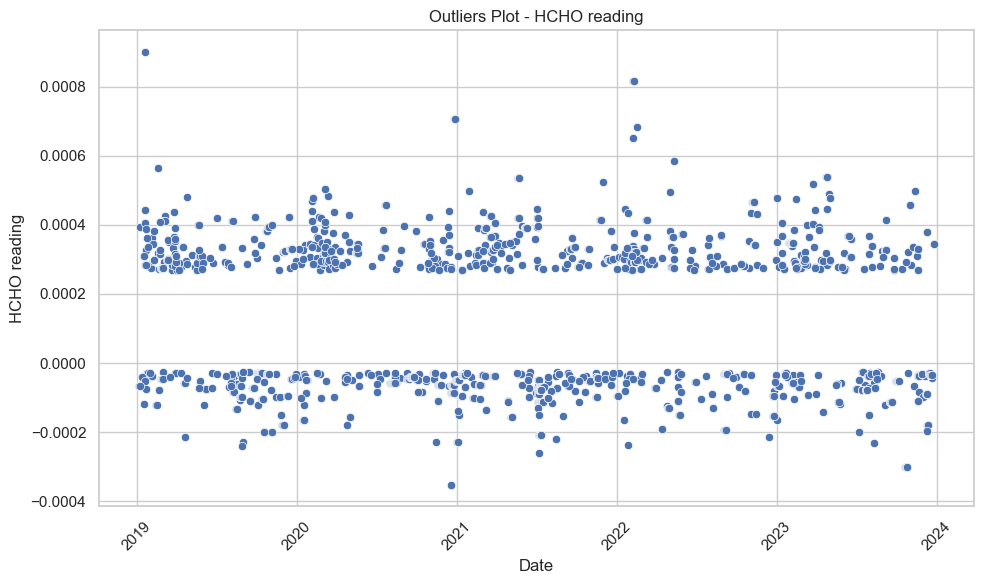

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Iterate over numeric columns to plot outliers
for column in numeric_columns:
    # Skip non-numeric columns
    if concatenated_data[column].dtype not in ['int64', 'float64']:
        continue

    # Define upper and lower bounds for the current column
    lower_bound = lower_bound
    upper_bound = upper_bound

    # Find outliers for the current column
    column_outliers = concatenated_data[(concatenated_data[column] < lower_bound) | (concatenated_data[column] > upper_bound)]

    # Plot outliers using scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=column_outliers, x='Current Date', y=column)
    plt.title(f'Outliers Plot - {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [11]:
print(concatenated_data_cleaned)

      HCHO reading        Location Current Date   Next Date
0         0.000263  Colombo Proper   2019-01-02  2019-01-03
1         0.000099  Colombo Proper   2019-01-03  2019-01-04
2         0.000210  Colombo Proper   2019-01-04  2019-01-05
3         0.000179  Colombo Proper   2019-01-05  2019-01-06
4         0.000108  Colombo Proper   2019-01-06  2019-01-07
...            ...             ...          ...         ...
1820      0.000116    Kandy Proper   2023-12-27  2023-12-28
1821      0.000116    Kandy Proper   2023-12-28  2023-12-29
1822      0.000116    Kandy Proper   2023-12-29  2023-12-30
1823      0.000056    Kandy Proper   2023-12-30  2023-12-31
1824      0.000056    Kandy Proper   2023-12-31  2024-01-01

[12779 rows x 4 columns]


Compute descriptive statistics

In [12]:
# Ensure data types are correct, especially for 'HCHO reading' column
concatenated_data_cleaned['HCHO reading'] = pd.to_numeric(concatenated_data_cleaned['HCHO reading'], errors='coerce')

# Compute descriptive statistics for each city
city_statistics = concatenated_data_cleaned.groupby('Location')['HCHO reading'].agg(['mean', 'median', 'std'])

# Compute descriptive statistics for the entire dataset
overall_statistics = concatenated_data_cleaned['HCHO reading'].agg(['mean', 'median', 'std'])

# Display the statistics
print("Descriptive statistics for each city:")
print(city_statistics)

print("\nDescriptive statistics for the entire dataset:")
print(overall_statistics)


Descriptive statistics for each city:
                         mean    median       std
Location                                         
Bibile, Monaragala   0.000120  0.000120  0.000082
Colombo Proper       0.000148  0.000145  0.000082
Deniyaya, Matara     0.000093  0.000082  0.000079
Jaffna Proper        0.000106  0.000099  0.000068
Kandy Proper         0.000101  0.000100  0.000079
Kurunegala Proper    0.000124  0.000118  0.000078
Nuwara Eliya Proper  0.000093  0.000083  0.000078

Descriptive statistics for the entire dataset:
mean      0.000112
median    0.000107
std       0.000080
Name: HCHO reading, dtype: float64


In [13]:
print(concatenated_data_cleaned)

      HCHO reading        Location Current Date   Next Date
0         0.000263  Colombo Proper   2019-01-02  2019-01-03
1         0.000099  Colombo Proper   2019-01-03  2019-01-04
2         0.000210  Colombo Proper   2019-01-04  2019-01-05
3         0.000179  Colombo Proper   2019-01-05  2019-01-06
4         0.000108  Colombo Proper   2019-01-06  2019-01-07
...            ...             ...          ...         ...
1820      0.000116    Kandy Proper   2023-12-27  2023-12-28
1821      0.000116    Kandy Proper   2023-12-28  2023-12-29
1822      0.000116    Kandy Proper   2023-12-29  2023-12-30
1823      0.000056    Kandy Proper   2023-12-30  2023-12-31
1824      0.000056    Kandy Proper   2023-12-31  2024-01-01

[12779 rows x 4 columns]


HCHO Distribution of each city

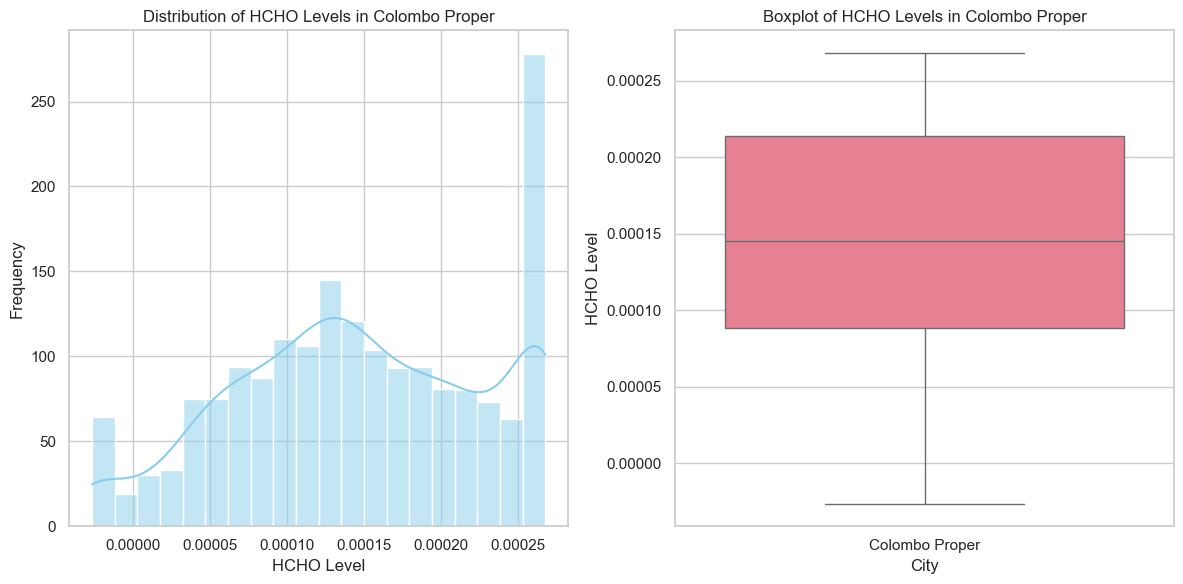

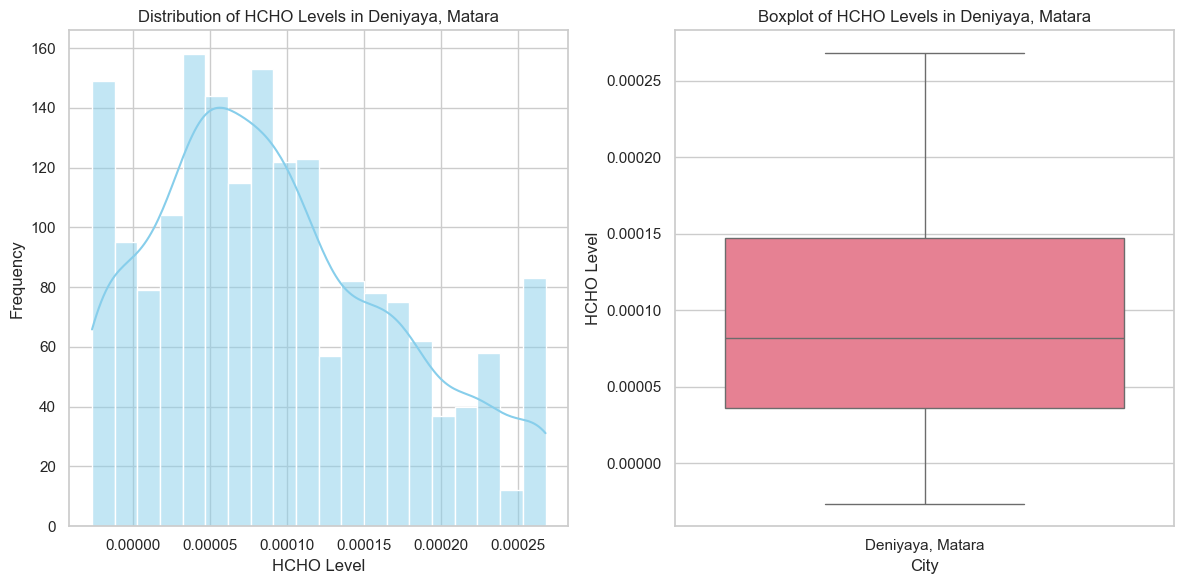

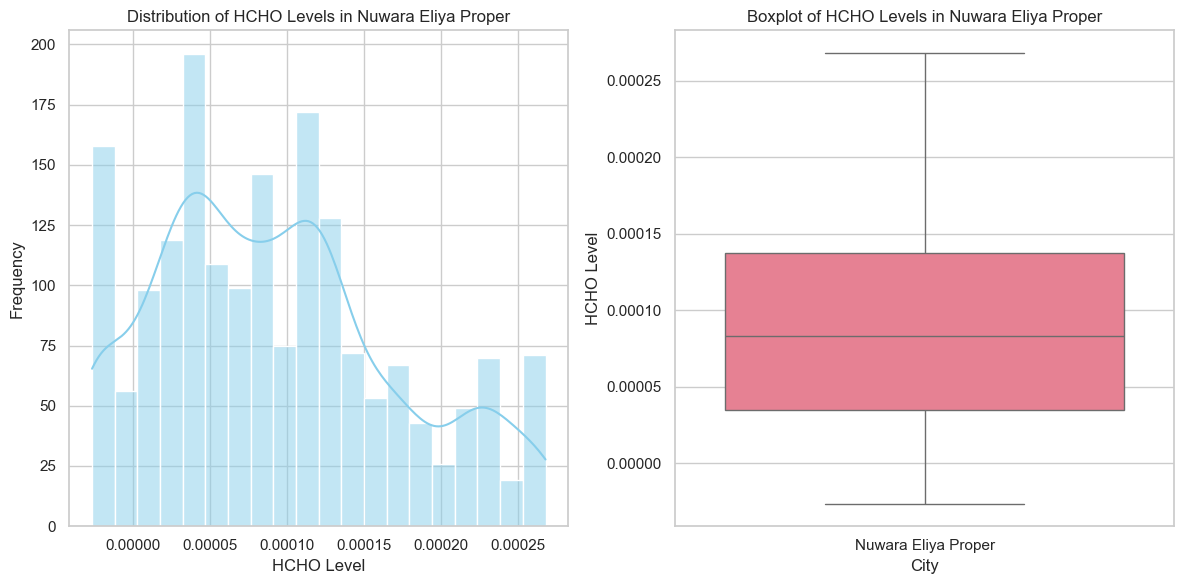

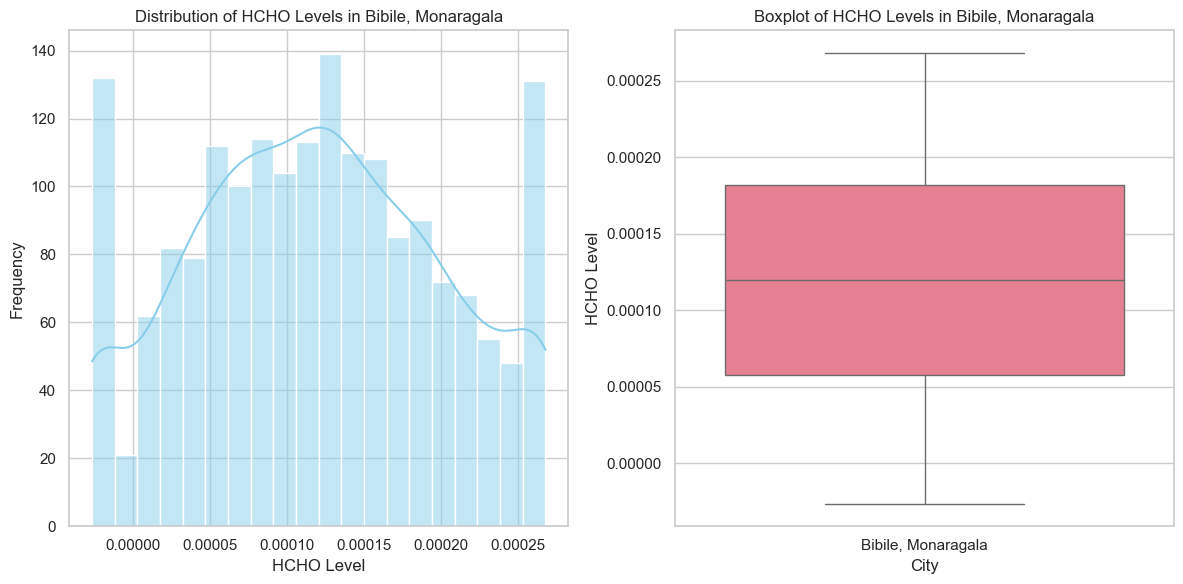

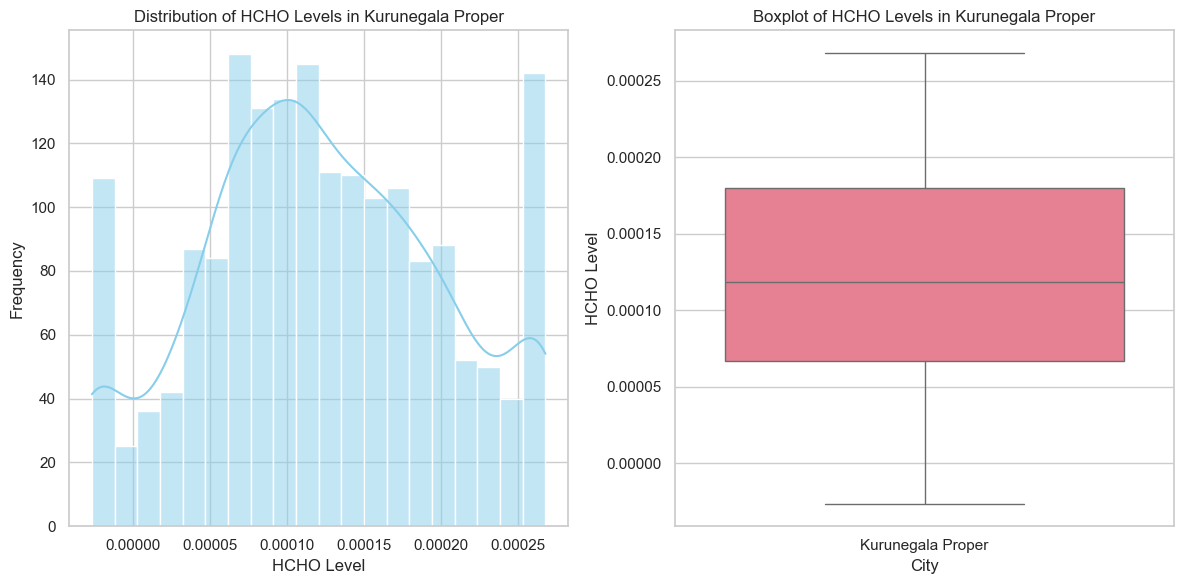

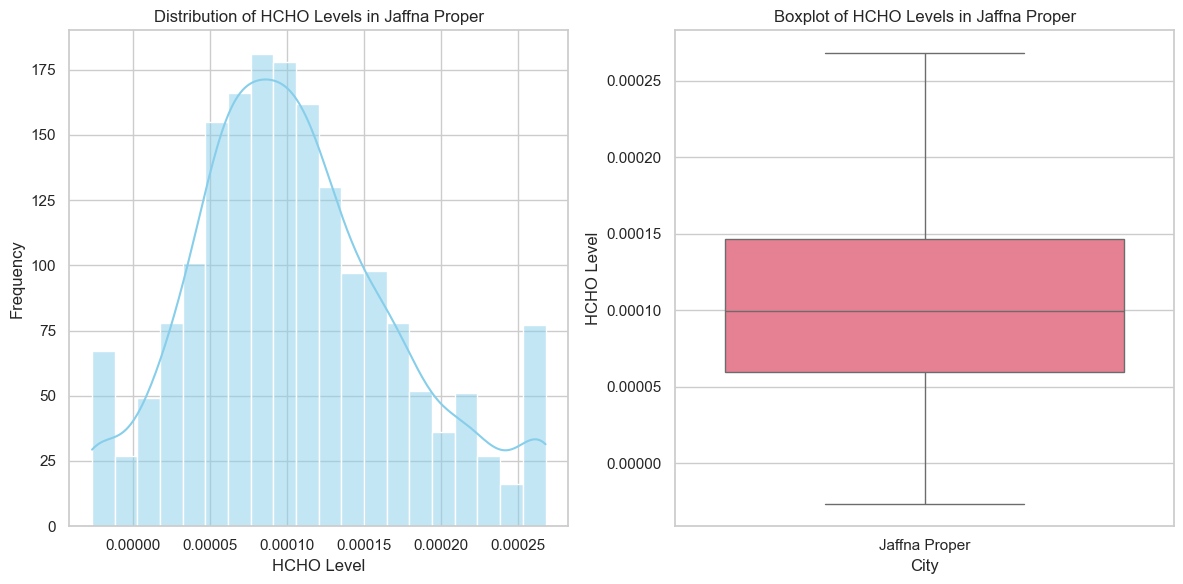

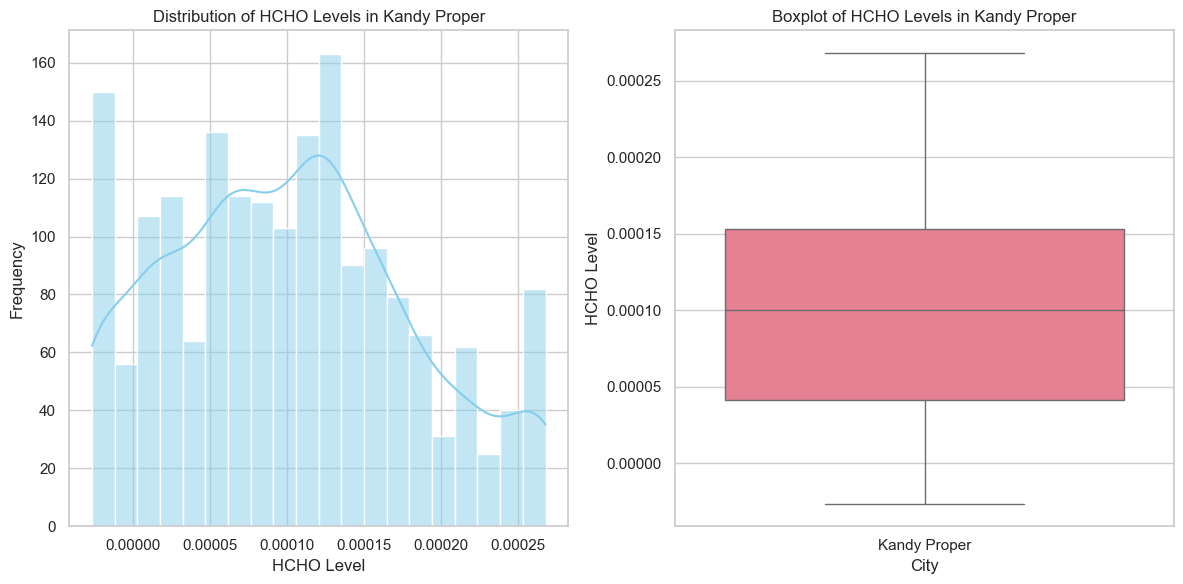

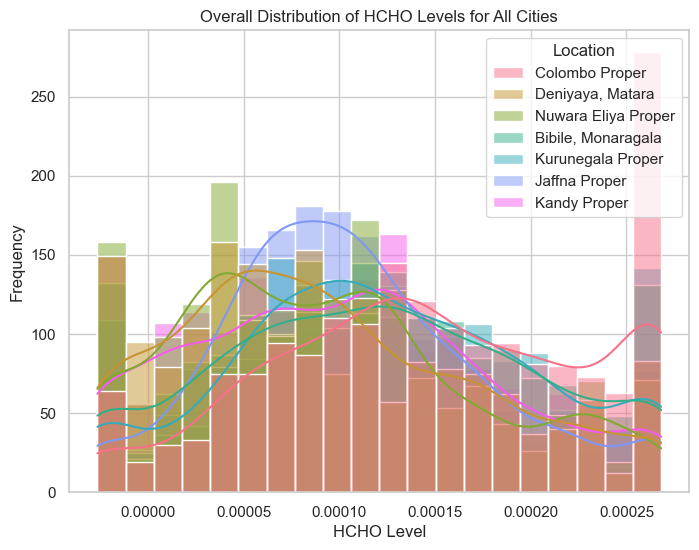

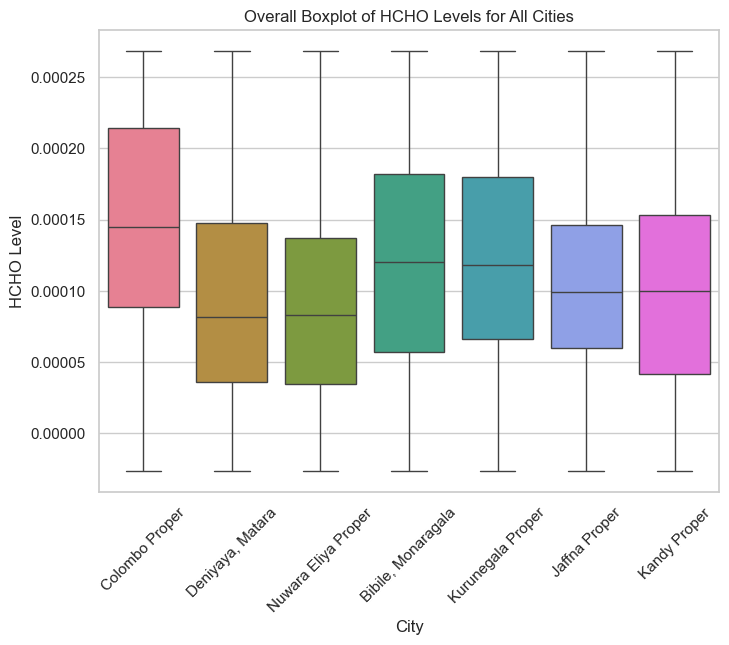

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Iterate over each city
for city in concatenated_data_cleaned['Location'].unique():
    # Filter data for the current city
    city_data = concatenated_data_cleaned[concatenated_data_cleaned['Location'] == city]

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot histogram
    sns.histplot(data=city_data, x='HCHO reading', bins=20, kde=True, color='skyblue', ax=axs[0])
    axs[0].set_title(f'Distribution of HCHO Levels in {city}')
    axs[0].set_xlabel('HCHO Level')
    axs[0].set_ylabel('Frequency')

    # Plot boxplot
    sns.boxplot(data=city_data, x='Location', y='HCHO reading', hue='Location', palette='husl', ax=axs[1], legend=False)
    axs[1].set_title(f'Boxplot of HCHO Levels in {city}')
    axs[1].set_xlabel('City')
    axs[1].set_ylabel('HCHO Level')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Create overall histogram for all cities with different colors
plt.figure(figsize=(8, 6))
sns.histplot(data=concatenated_data_cleaned, x='HCHO reading', bins=20, kde=True, hue='Location', palette='husl')
plt.title('Overall Distribution of HCHO Levels for All Cities')
plt.xlabel('HCHO Level')
plt.ylabel('Frequency')
plt.show()

# Create overall boxplot for all cities with different colors
plt.figure(figsize=(8, 6))
sns.boxplot(data=concatenated_data_cleaned, x='Location', y='HCHO reading', palette='husl')
plt.title('Overall Boxplot of HCHO Levels for All Cities')
plt.xlabel('City')
plt.ylabel('HCHO Level')
plt.xticks(rotation=45)
plt.show()


In [15]:
print(concatenated_data_cleaned['Current Date'].dtype)
# Convert 'Current Date' column to datetime format
concatenated_data_cleaned['Current Date'] = pd.to_datetime(concatenated_data_cleaned['Current Date'])


object


 Identify seasonal variations

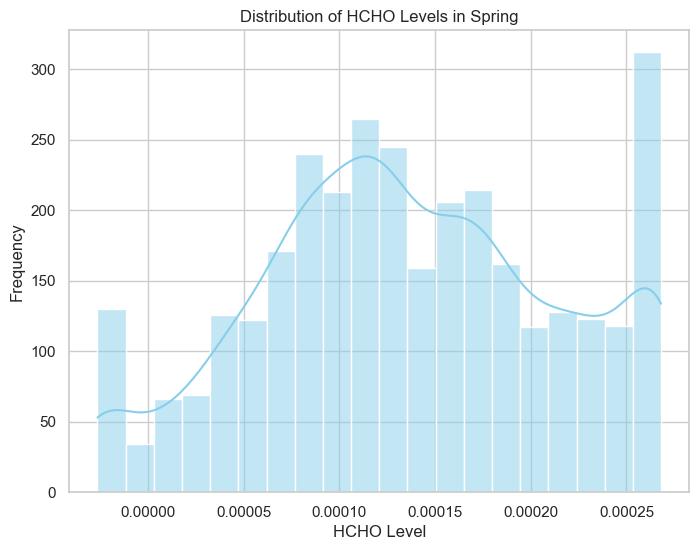

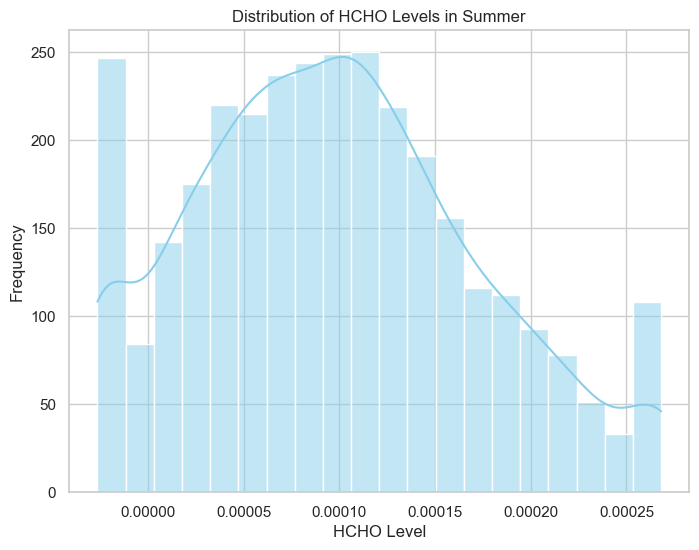

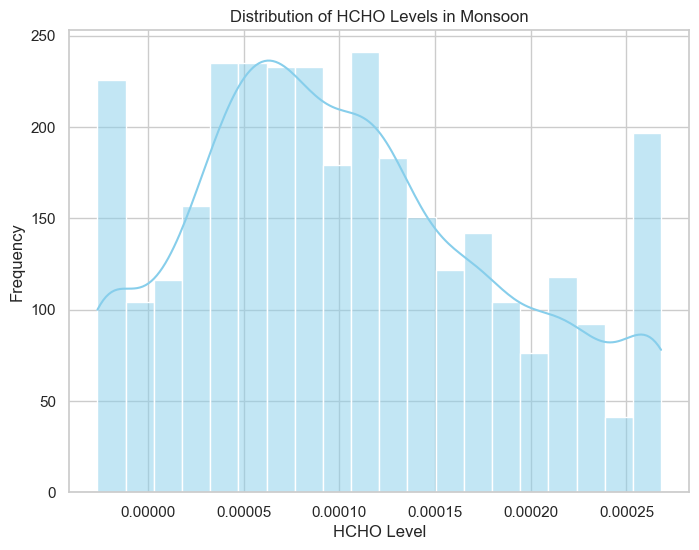

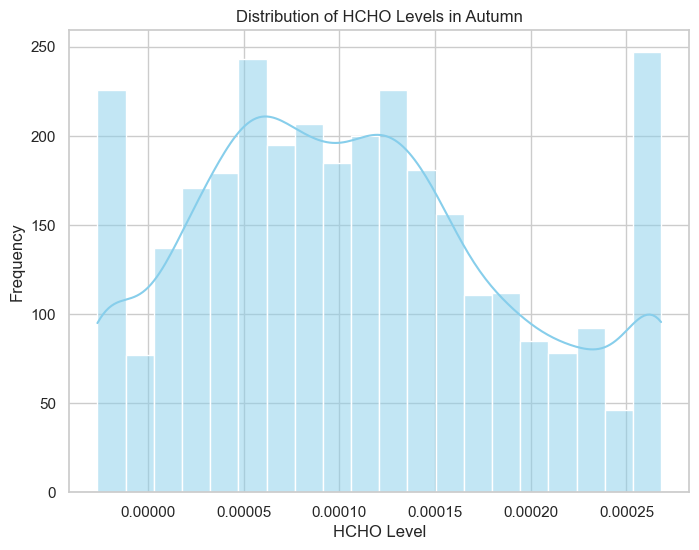

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Define seasons and their corresponding months
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Monsoon': [9, 10, 11],
    'Autumn': [12, 1, 2]
}

# Distribution of HCHO Levels Across Seasons
for season, months in seasons.items():
    # Filter data for the current season
    season_data = concatenated_data_cleaned[concatenated_data_cleaned['Current Date'].dt.month.isin(months)]

    # Create histogram for the current season
    plt.figure(figsize=(8, 6))
    sns.histplot(data=season_data, x='HCHO reading', bins=20, kde=True, color='skyblue')
    plt.title(f'Distribution of HCHO Levels in {season}')
    plt.xlabel('HCHO Level')
    plt.ylabel('Frequency')
    plt.show()


In [17]:
print(concatenated_data_cleaned)

      HCHO reading        Location Current Date   Next Date
0         0.000263  Colombo Proper   2019-01-02  2019-01-03
1         0.000099  Colombo Proper   2019-01-03  2019-01-04
2         0.000210  Colombo Proper   2019-01-04  2019-01-05
3         0.000179  Colombo Proper   2019-01-05  2019-01-06
4         0.000108  Colombo Proper   2019-01-06  2019-01-07
...            ...             ...          ...         ...
1820      0.000116    Kandy Proper   2023-12-27  2023-12-28
1821      0.000116    Kandy Proper   2023-12-28  2023-12-29
1822      0.000116    Kandy Proper   2023-12-29  2023-12-30
1823      0.000056    Kandy Proper   2023-12-30  2023-12-31
1824      0.000056    Kandy Proper   2023-12-31  2024-01-01

[12779 rows x 4 columns]


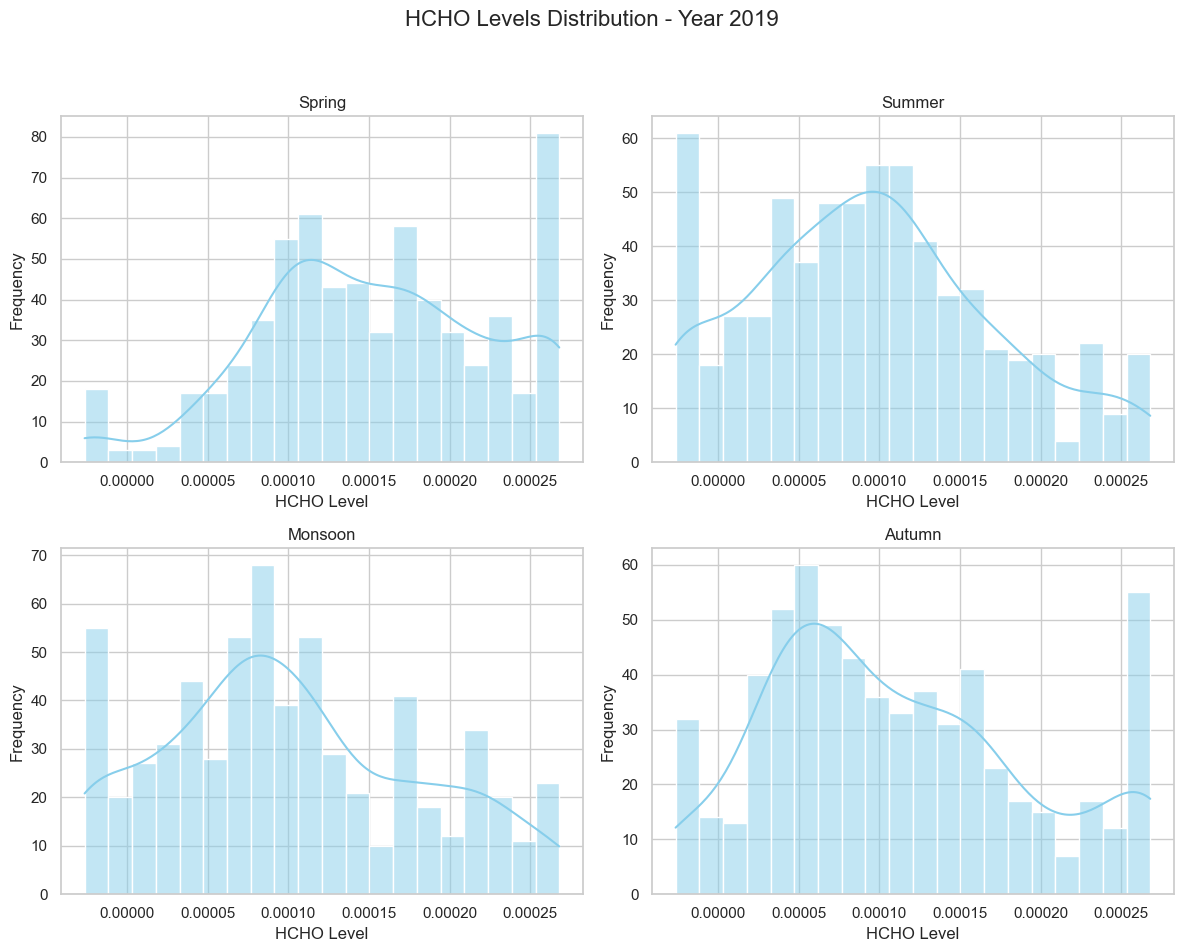

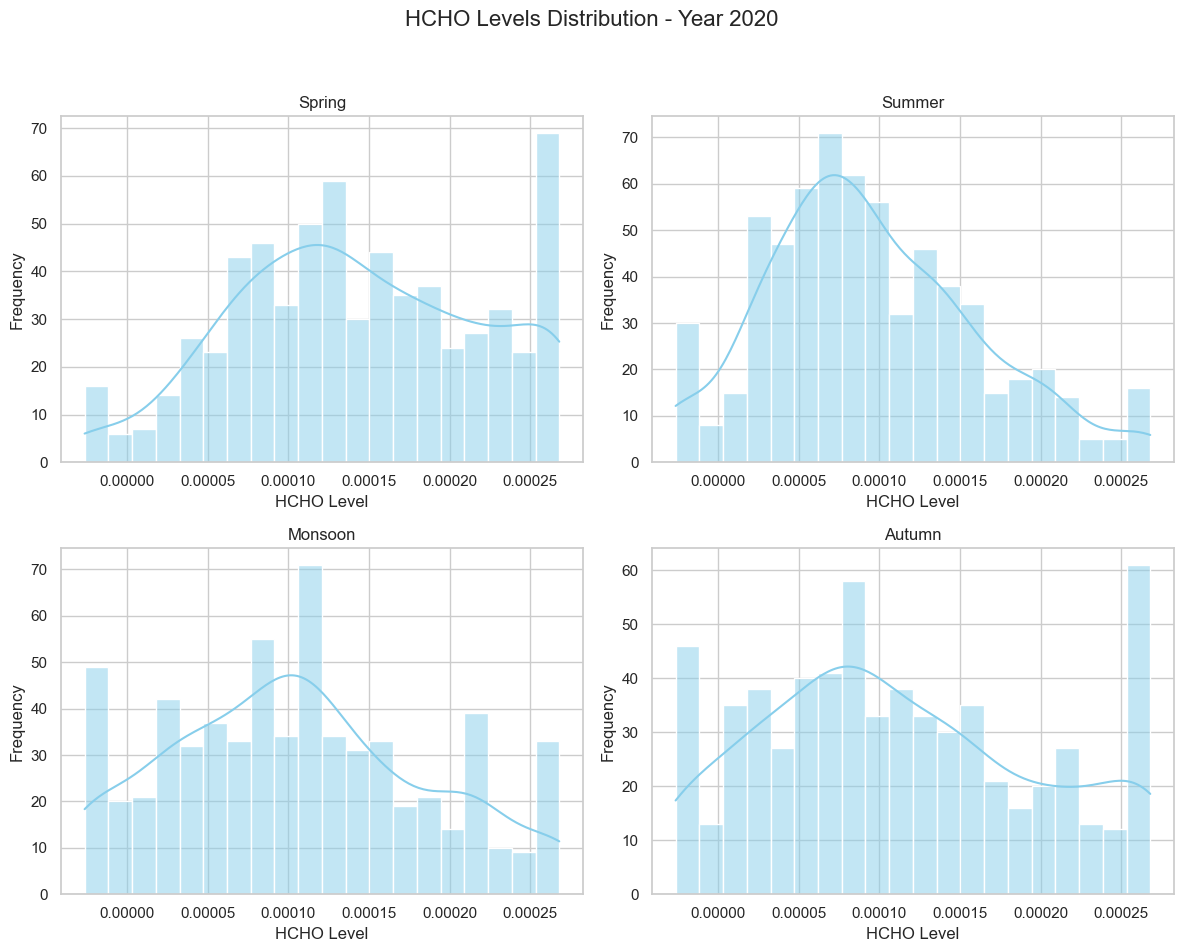

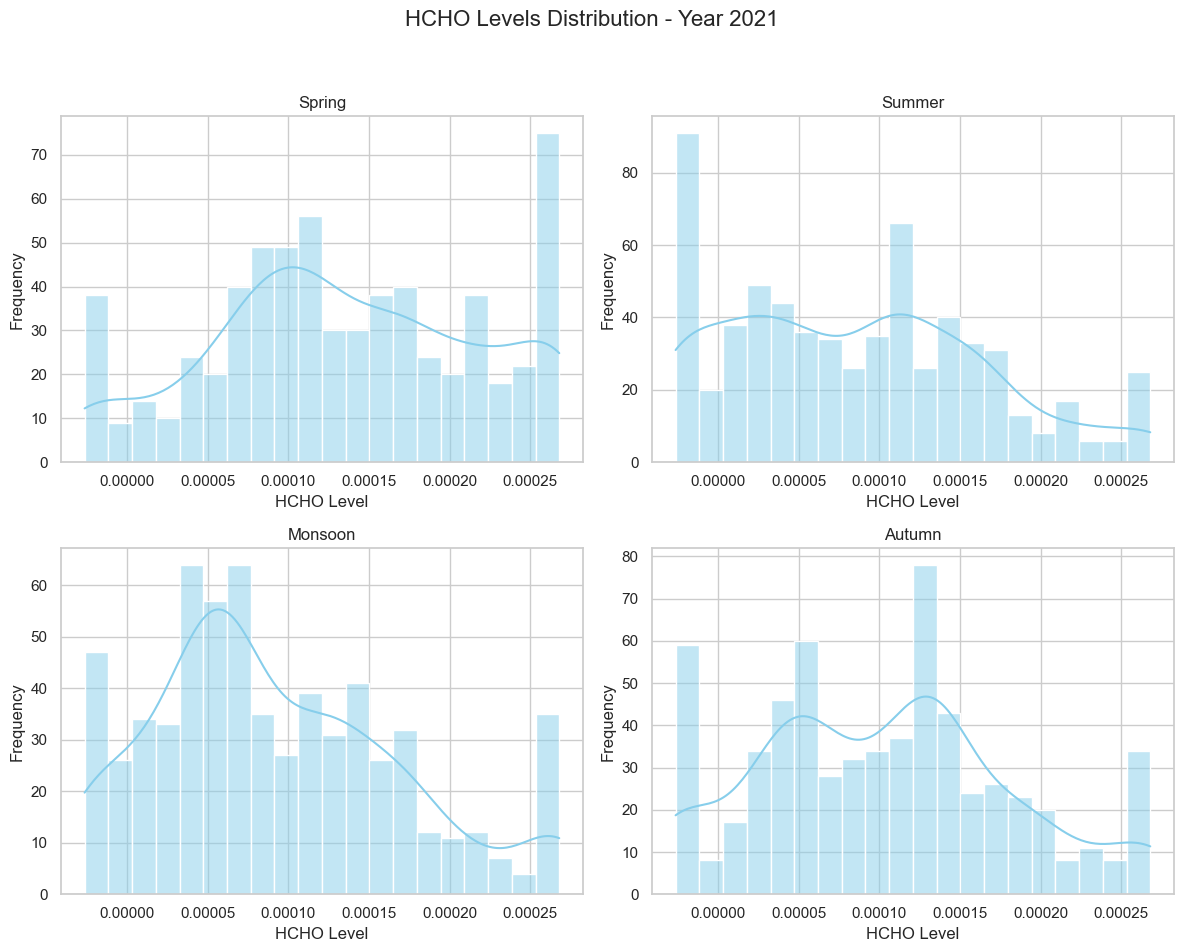

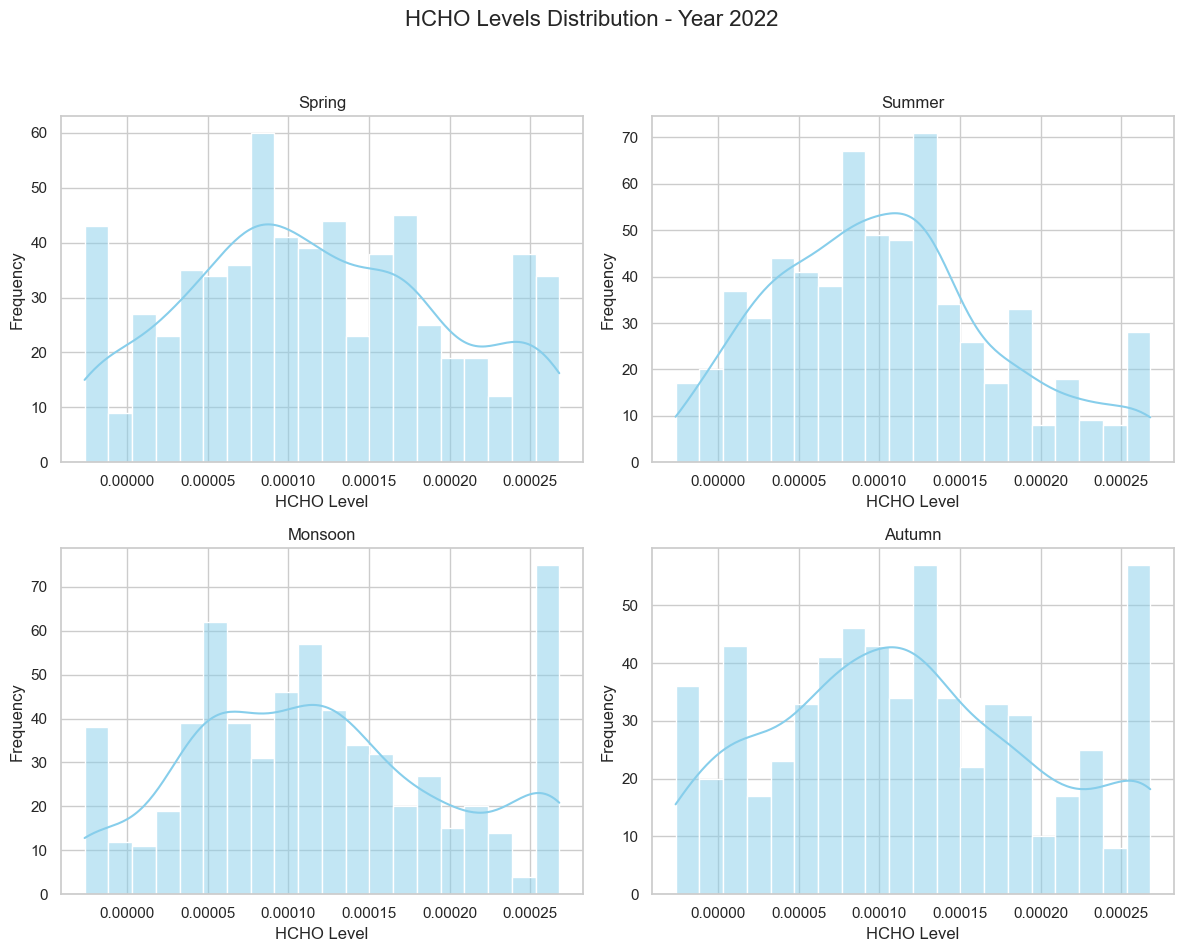

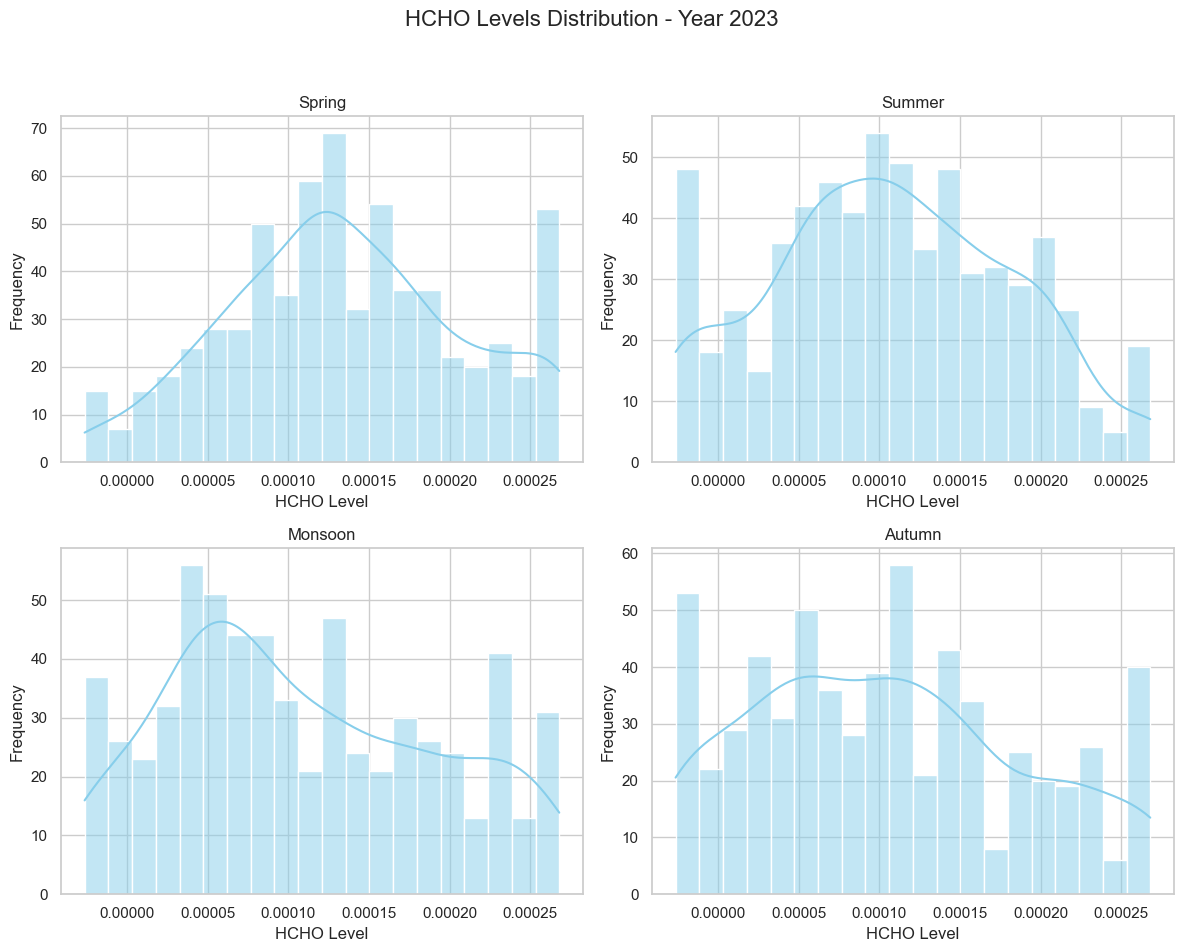

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Define seasons and their corresponding months
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Monsoon': [9, 10, 11],
    'Autumn': [12, 1, 2]
}

# Distribution of HCHO Levels Across Years
for year in concatenated_data_cleaned['Current Date'].dt.year.unique():
    # Check if year is not NaN
    if not pd.isnull(year):
        # Create a new figure for each year
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f'HCHO Levels Distribution - Year {int(year)}', fontsize=16)

        # Flatten the axes array for easier iteration
        axs = axs.flatten()

        # Iterate over each season
        for i, (season, months) in enumerate(seasons.items()):
            # Filter data for the current season and year
            season_data = concatenated_data_cleaned[
                (concatenated_data_cleaned['Current Date'].dt.month.isin(months)) &
                (concatenated_data_cleaned['Current Date'].dt.year == year)
            ]

            # Create histogram for the current season
            sns.histplot(data=season_data, x='HCHO reading', bins=20, kde=True, ax=axs[i], color='skyblue')
            axs[i].set_title(f'{season}')
            axs[i].set_xlabel('HCHO Level')
            axs[i].set_ylabel('Frequency')

        # Adjust layout to avoid overlap
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Show the plot for the current year
        plt.show()


In [19]:
print(concatenated_data_cleaned)

      HCHO reading        Location Current Date   Next Date
0         0.000263  Colombo Proper   2019-01-02  2019-01-03
1         0.000099  Colombo Proper   2019-01-03  2019-01-04
2         0.000210  Colombo Proper   2019-01-04  2019-01-05
3         0.000179  Colombo Proper   2019-01-05  2019-01-06
4         0.000108  Colombo Proper   2019-01-06  2019-01-07
...            ...             ...          ...         ...
1820      0.000116    Kandy Proper   2023-12-27  2023-12-28
1821      0.000116    Kandy Proper   2023-12-28  2023-12-29
1822      0.000116    Kandy Proper   2023-12-29  2023-12-30
1823      0.000056    Kandy Proper   2023-12-30  2023-12-31
1824      0.000056    Kandy Proper   2023-12-31  2024-01-01

[12779 rows x 4 columns]


Trends in HCHO levels in each city

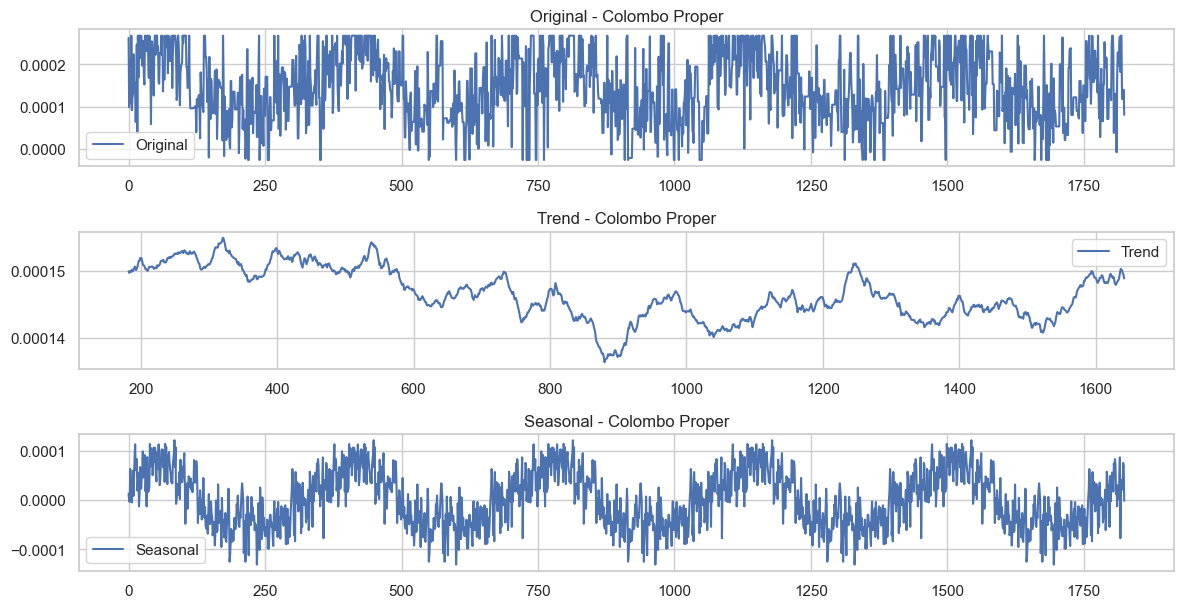

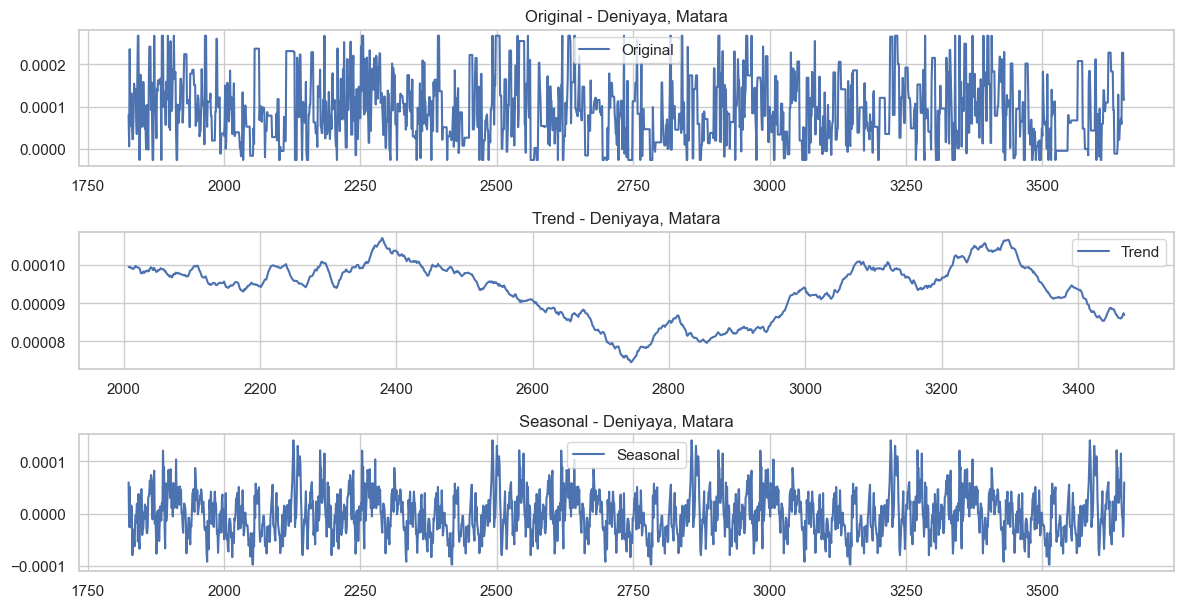

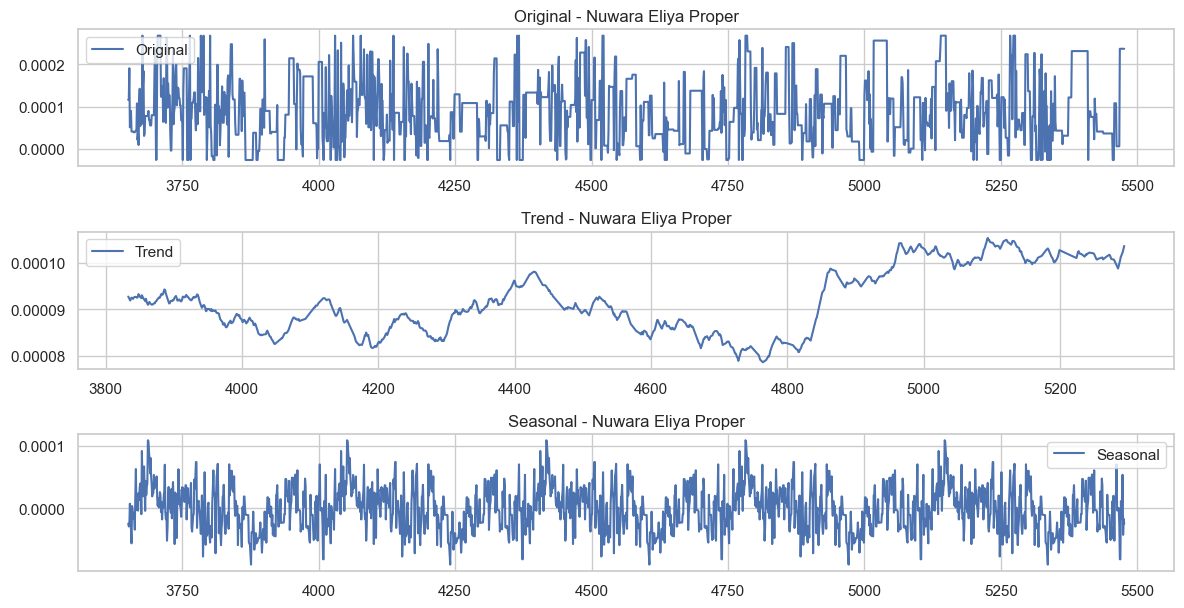

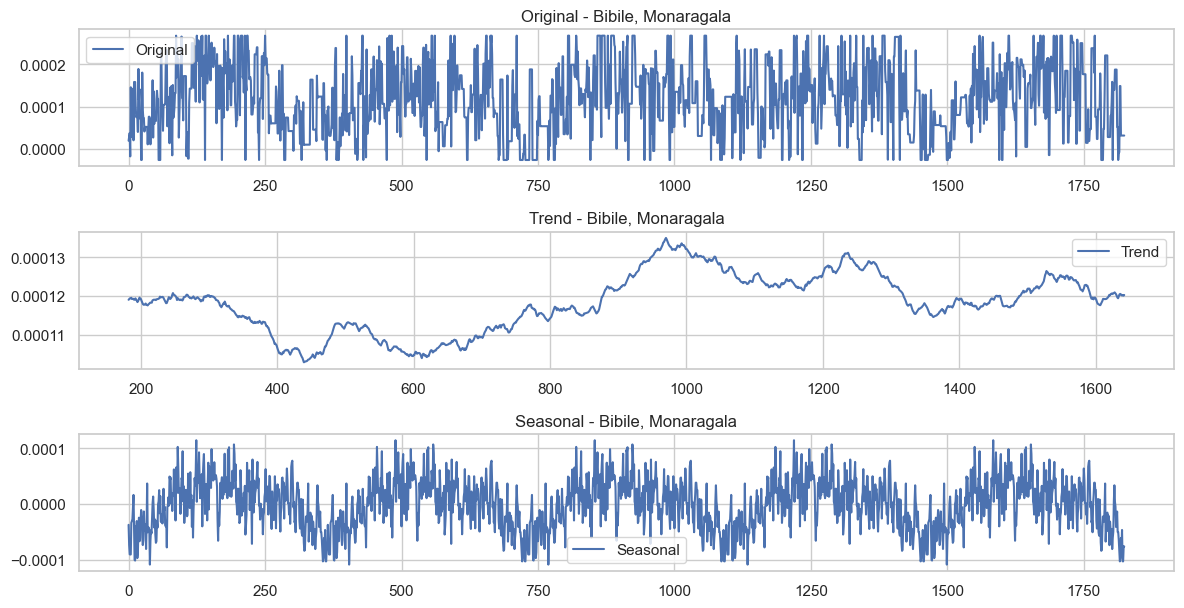

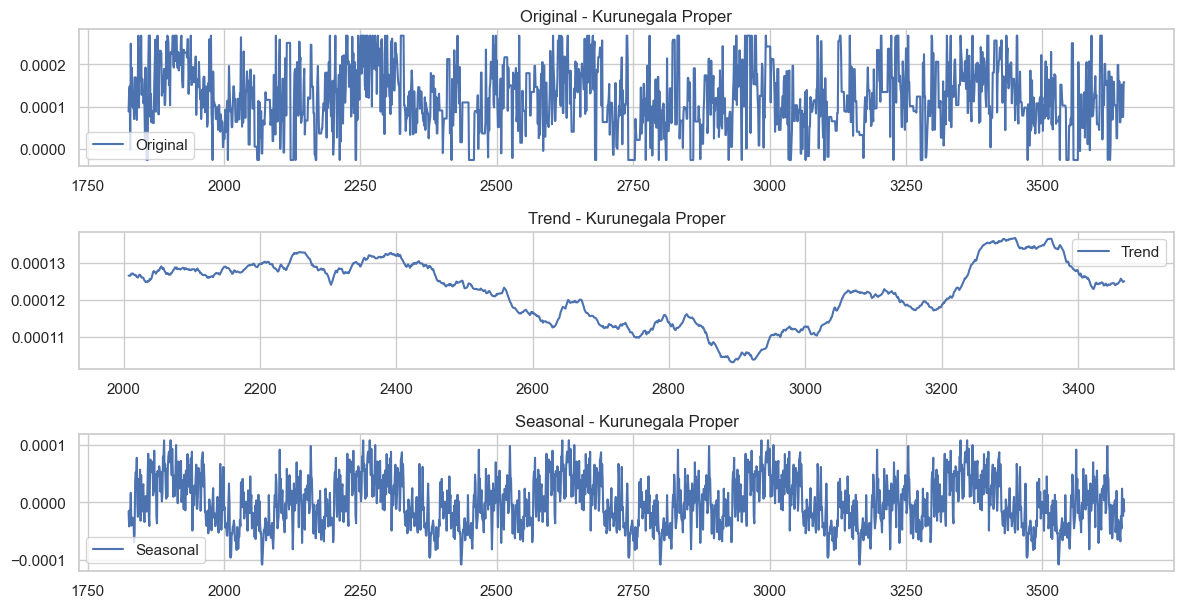

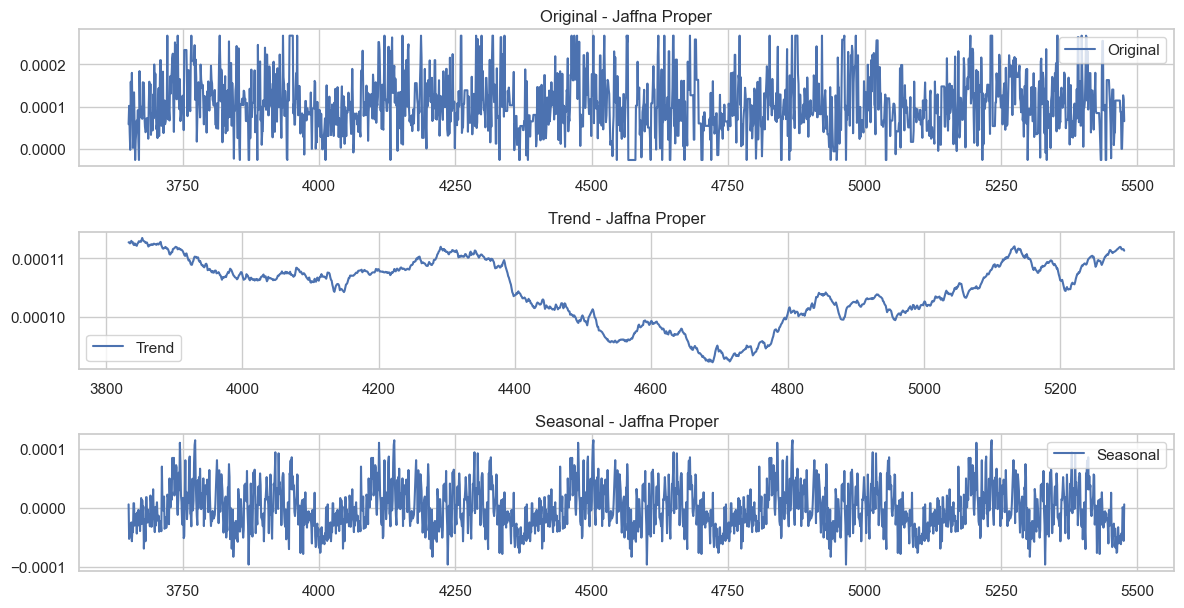

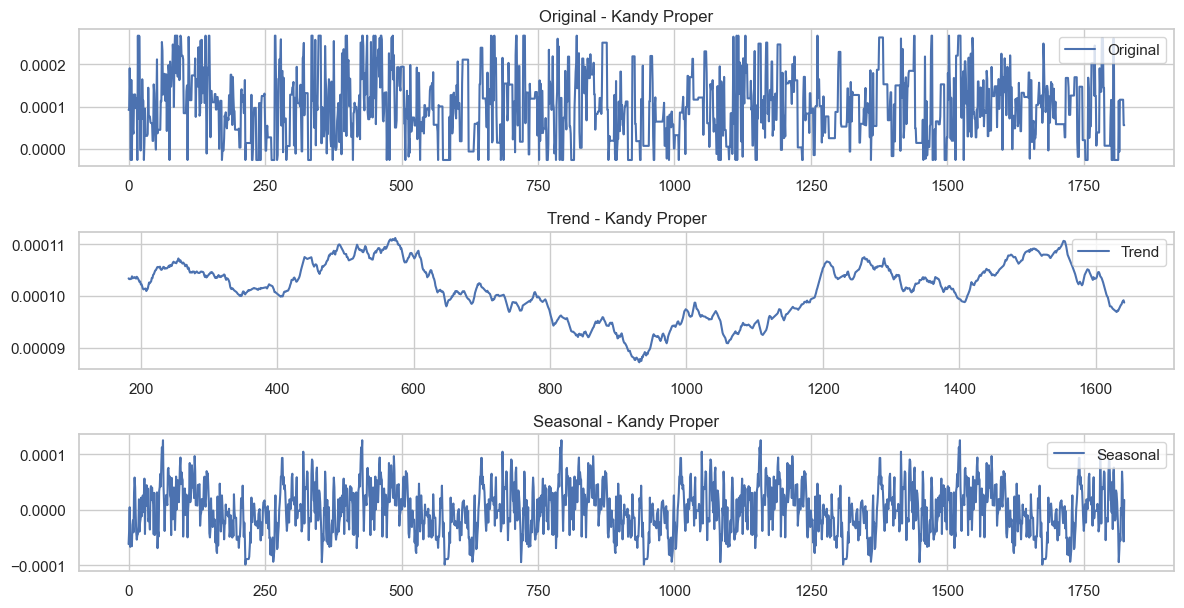

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the style of seaborn
sns.set(style="whitegrid")

# Iterate over each city
for city in concatenated_data_cleaned['Location'].unique():
    # Filter data for the current city
    city_data = concatenated_data_cleaned[concatenated_data_cleaned['Location'] == city]

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(city_data['HCHO reading'], model='additive', period=365)

    # Extract components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot components
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(city_data['HCHO reading'], label='Original')
    plt.title(f'Original - {city}')  # Add city name to the title
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.title(f'Trend - {city}')  # Add city name to the title
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.title(f'Seasonal - {city}')  # Add city name to the title
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()


Covid - 19 Pandemic

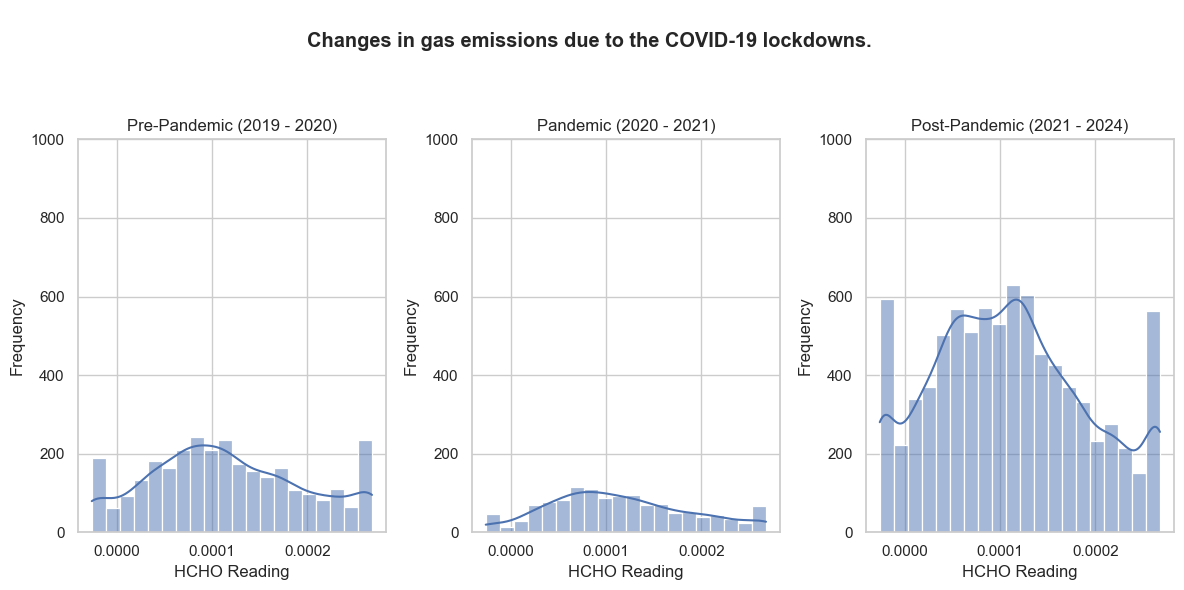

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the periods
pre_pandemic_start = pd.Timestamp('2019-01-01')
pandemic_start = pd.Timestamp('2020-03-12')
post_pandemic_start = pd.Timestamp('2020-09-10')
post_pandemic_end = pd.Timestamp('2024-01-01')

# Filter the dataset for each period
pre_pandemic_data = concatenated_data_cleaned[concatenated_data_cleaned['Current Date'] < pandemic_start]
pandemic_data = concatenated_data_cleaned[(concatenated_data_cleaned['Current Date'] >= pandemic_start) &
                                          (concatenated_data_cleaned['Current Date'] < post_pandemic_start)]
post_pandemic_data = concatenated_data_cleaned[concatenated_data_cleaned['Current Date'] >= post_pandemic_start]

# Plot the distribution of HCHO readings for each period separately
plt.figure(figsize=(12, 6))
plt.suptitle("\nChanges in gas emissions due to the COVID-19 lockdowns. \n\n", fontweight='bold')
# Pre-pandemic period
plt.subplot(1, 3, 1)
sns.histplot(data=pre_pandemic_data, x='HCHO reading', kde=True, bins=20)
plt.title('Pre-Pandemic (2019 - 2020)')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.ylim(0, 1000)

# Pandemic period
plt.subplot(1, 3, 2)
sns.histplot(data=pandemic_data, x='HCHO reading', kde=True, bins=20)
plt.title('Pandemic (2020 - 2021)')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.ylim(0, 1000)

# Post-pandemic period
plt.subplot(1, 3, 3)
sns.histplot(data=post_pandemic_data, x='HCHO reading', kde=True, bins=20)
plt.title('Post-Pandemic (2021 - 2024)')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.ylim(0, 1000)

plt.tight_layout()
plt.show()


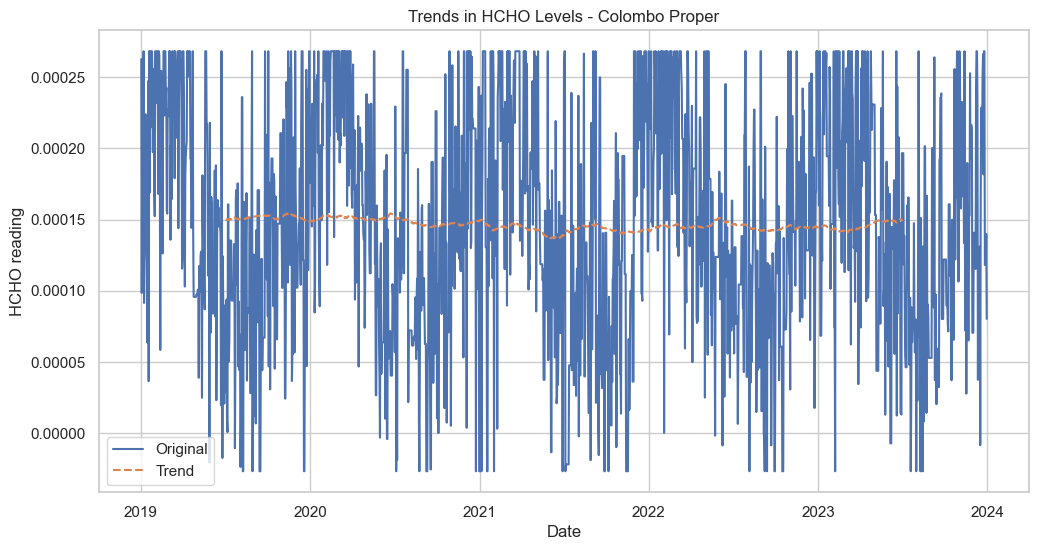

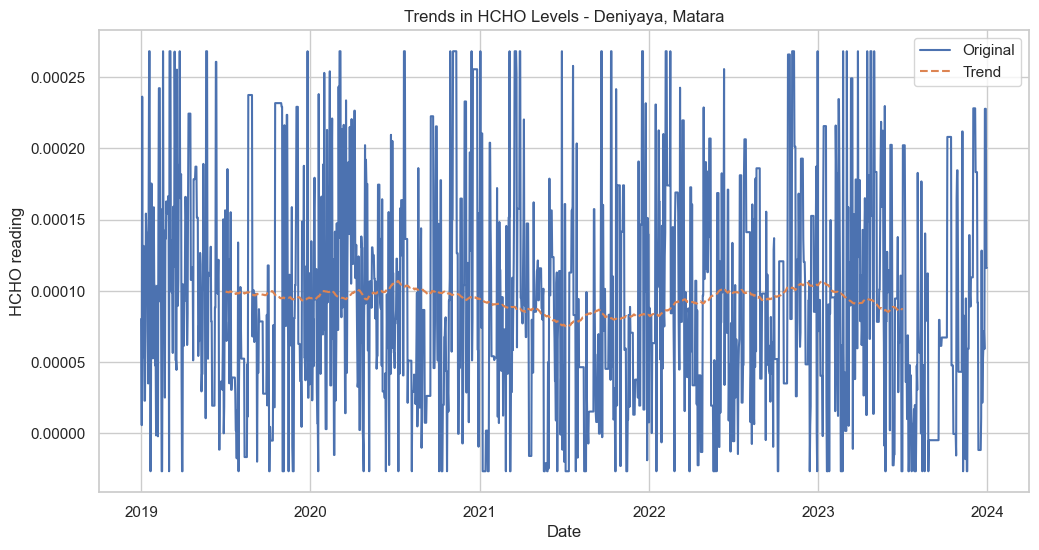

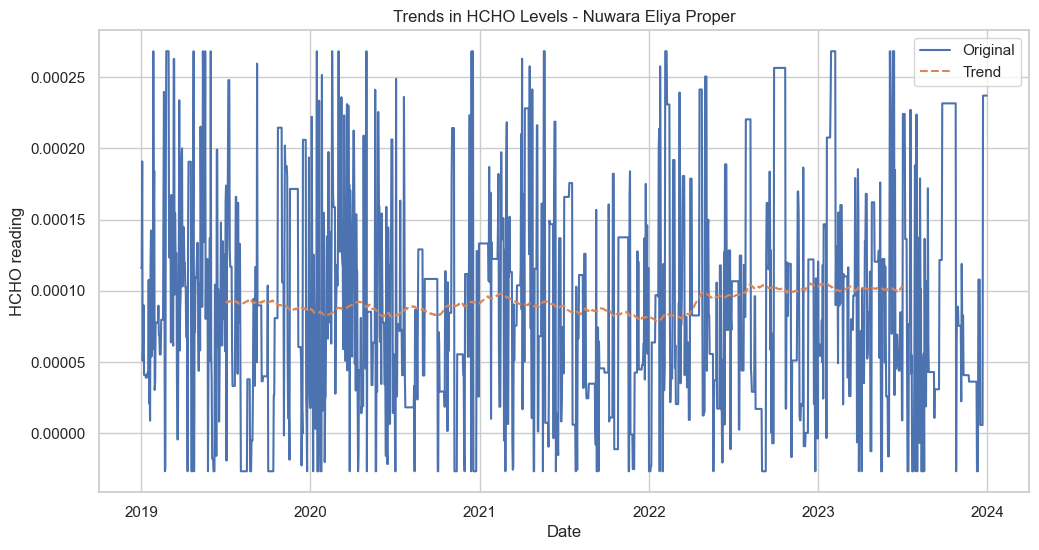

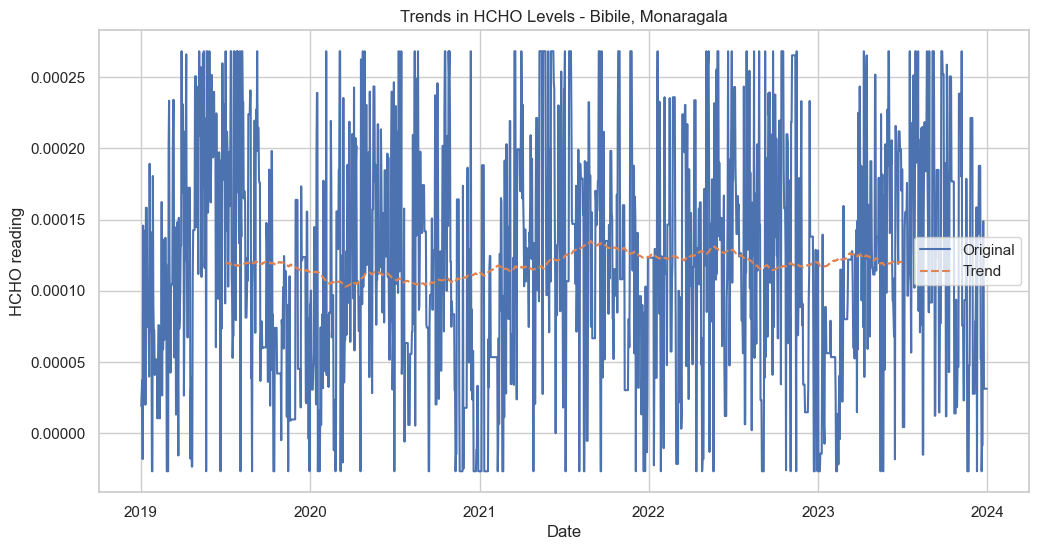

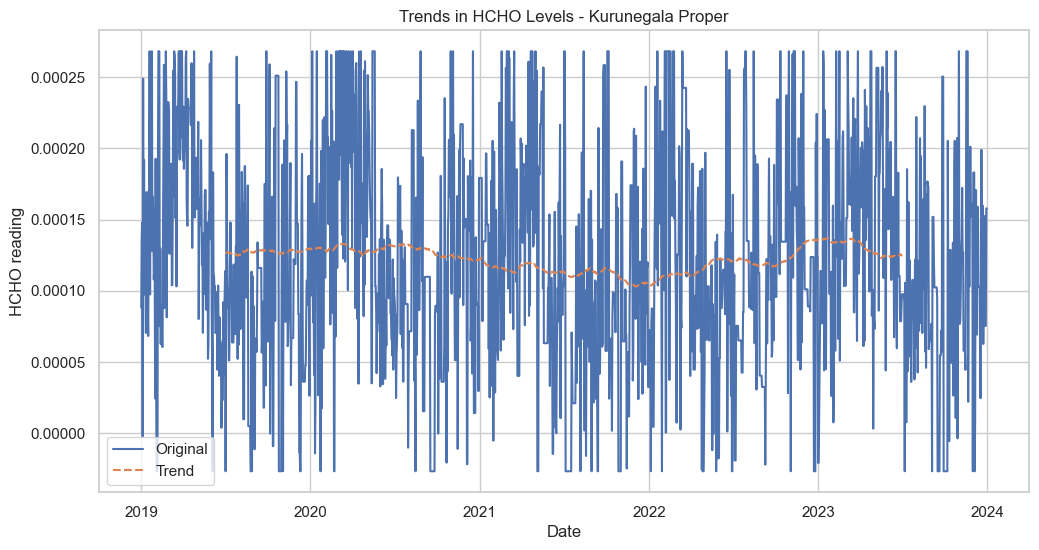

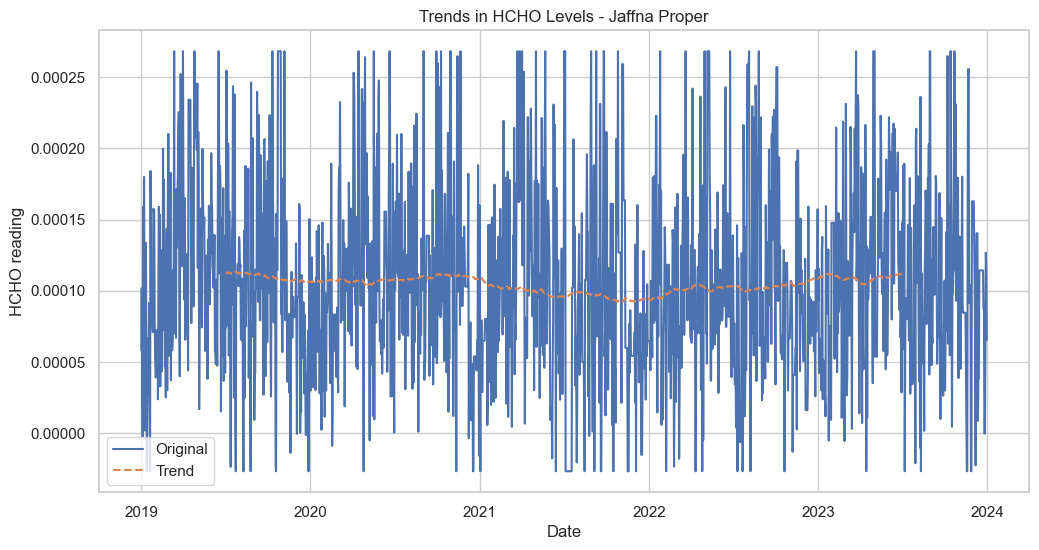

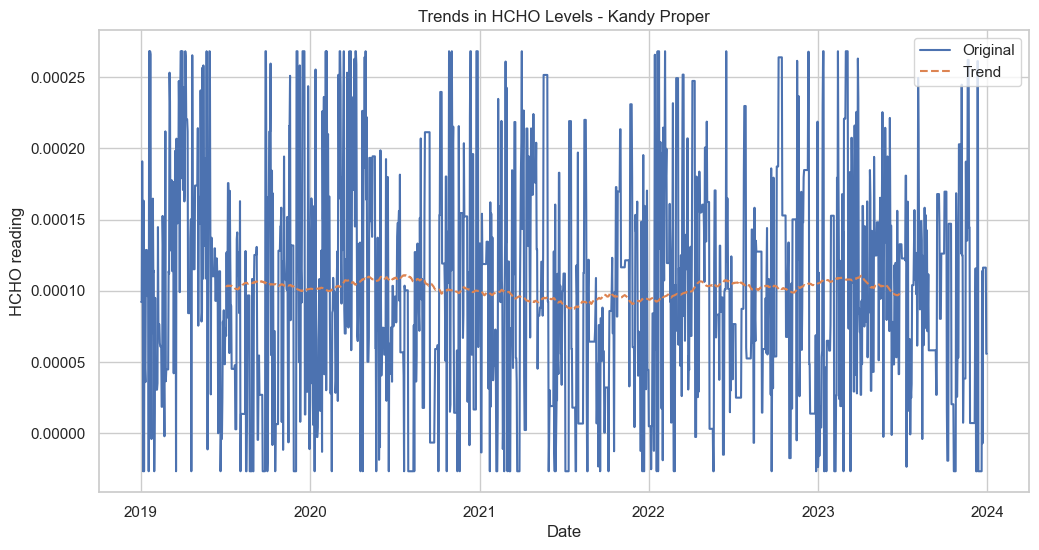

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_style("whitegrid")

# Perform time series analysis for each city
def analyze_trends(location):
    location_data = concatenated_data_cleaned[concatenated_data_cleaned['Location'] == location]

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(location_data['HCHO reading'], model='additive', period=365)

    # Extract trend component
    trend = decomposition.trend

    # Plot original data and trend
    plt.figure(figsize=(12, 6))
    plt.plot(location_data['Current Date'], location_data['HCHO reading'], label='Original')
    plt.plot(location_data['Current Date'], trend, label='Trend', linestyle='--')
    plt.title(f'Trends in HCHO Levels - {location}')
    plt.xlabel('Date')
    plt.ylabel('HCHO reading')
    plt.legend()
    plt.show()

# Get unique locations
unique_locations = concatenated_data_cleaned['Location'].unique()

# Plot trend analysis for each city
for location in unique_locations:
    analyze_trends(location)


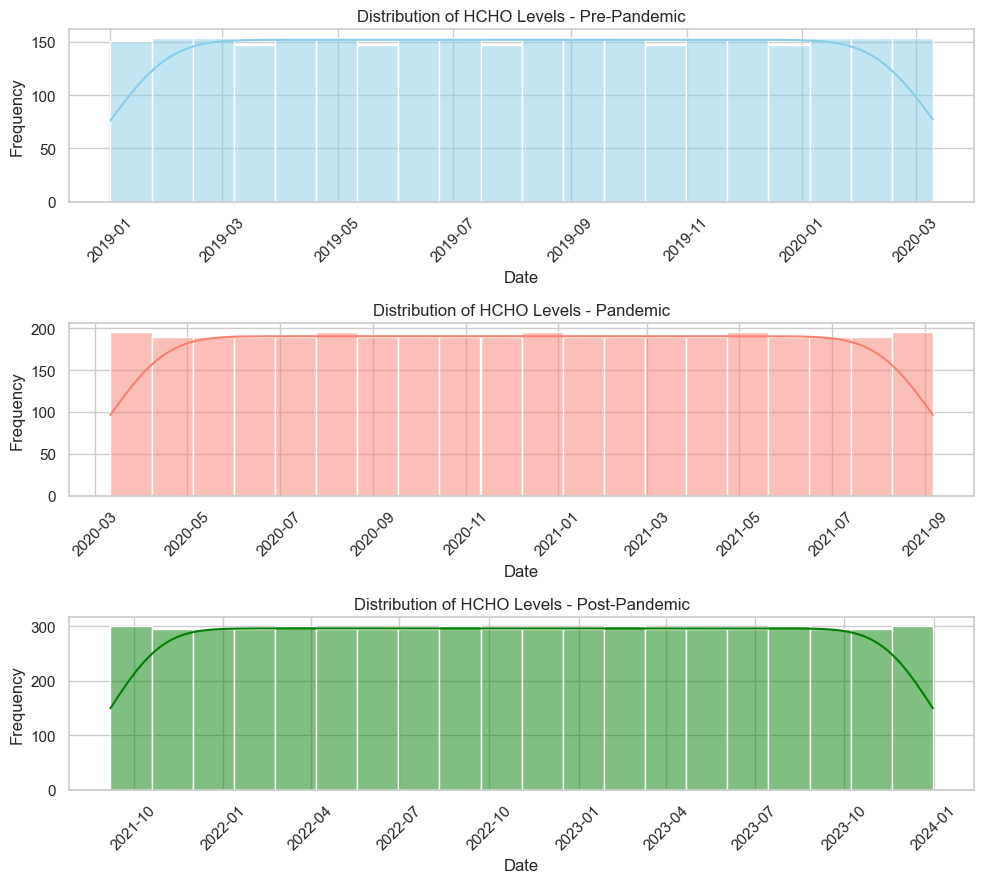

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Define the date ranges for pre-pandemic, pandemic, and post-pandemic periods
pre_pandemic_start = '2019-01-01'
pandemic_start = '2020-03-11'
pandemic_end = '2021-09-06'
post_pandemic_start = '2021-09-07'

# Filter data for each period
pre_pandemic_data = concatenated_data_cleaned[concatenated_data_cleaned['Current Date'] < pandemic_start]
pandemic_data = concatenated_data_cleaned[concatenated_data_cleaned['Current Date'].between(pandemic_start, pandemic_end)]
post_pandemic_data = concatenated_data_cleaned[concatenated_data_cleaned['Current Date'] >= post_pandemic_start]

# Plot histograms for HCHO levels for each period separately
plt.figure(figsize=(10, 9))

# Pre-pandemic histogram
plt.subplot(3, 1, 1)
sns.histplot(data=pre_pandemic_data, x='Current Date', bins=20, kde=True, color='skyblue')
plt.title('Distribution of HCHO Levels - Pre-Pandemic')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Pandemic histogram
plt.subplot(3, 1, 2)
sns.histplot(data=pandemic_data, x='Current Date', bins=20, kde=True, color='salmon')
plt.title('Distribution of HCHO Levels - Pandemic')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Post-pandemic histogram
plt.subplot(3, 1, 3)
sns.histplot(data=post_pandemic_data, x='Current Date', bins=20, kde=True, color='green')
plt.title('Distribution of HCHO Levels - Post-Pandemic')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# ARIMA model Implementation

In [34]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Iterate over each unique location
unique_locations_arima = concatenated_data_cleaned['Location'].unique()

for location_arima in unique_locations_arima:
    # Subset the data for the current location
    location_data_arima = concatenated_data_cleaned[concatenated_data_cleaned['Location'] == location_arima]

    # Apply ARIMA model
    model_arima = ARIMA(location_data_arima['HCHO reading'], order=(2, 0, 0))
    model_fit_arima = model_arima.fit()

    # Generate forecasts
    future_dates_arima = pd.date_range(start='2023-12-31', end='2024-01-30')
    pred_arima = model_fit_arima.predict(start=len(location_data_arima), end=len(location_data_arima)+30, type='levels').rename('Arima Predictions')
    pred_arima.index = future_dates_arima

    # Print or store the forecasts for each location
    print("")
    print("************************************")
    print(f"Forecasts for {location_arima}:\n")
    print(pred_arima)
    print("")



************************************
Forecasts for Colombo Proper:

2023-12-31    0.000116
2024-01-01    0.000122
2024-01-02    0.000131
2024-01-03    0.000135
2024-01-04    0.000139
2024-01-05    0.000142
2024-01-06    0.000144
2024-01-07    0.000145
2024-01-08    0.000146
2024-01-09    0.000146
2024-01-10    0.000147
2024-01-11    0.000147
2024-01-12    0.000147
2024-01-13    0.000147
2024-01-14    0.000147
2024-01-15    0.000147
2024-01-16    0.000147
2024-01-17    0.000148
2024-01-18    0.000148
2024-01-19    0.000148
2024-01-20    0.000148
2024-01-21    0.000148
2024-01-22    0.000148
2024-01-23    0.000148
2024-01-24    0.000148
2024-01-25    0.000148
2024-01-26    0.000148
2024-01-27    0.000148
2024-01-28    0.000148
2024-01-29    0.000148
2024-01-30    0.000148
Freq: D, Name: Arima Predictions, dtype: float64


************************************
Forecasts for Deniyaya, Matara:

2023-12-31    0.000107
2024-01-01    0.000102
2024-01-02    0.000099
2024-01-03    0.000097
2024-

In [35]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize lists to store evaluation metrics
mae_list = []
mse_list = []
rmse_list = []

# Iterate over each unique location
unique_locations_arima = concatenated_data_cleaned['Location'].unique()

for location_arima in unique_locations_arima:
    # Subset the data for the current location
    location_data_arima = concatenated_data_cleaned[concatenated_data_cleaned['Location'] == location_arima]

    # Apply ARIMA model
    model_arima = ARIMA(location_data_arima['HCHO reading'], order=(2, 0, 0))
    model_fit_arima = model_arima.fit()

    # Generate forecasts
    future_dates_arima = pd.date_range(start='2023-12-31', end='2024-01-30')
    pred_arima = model_fit_arima.predict(start=len(location_data_arima), end=len(location_data_arima)+30, typ='levels').rename('Arima Predictions')
    pred_arima.index = future_dates_arima

    # Actual values
    actual_values = location_data_arima['HCHO reading'].values[-31:]

    # Ensure the lengths match
    actual_values = actual_values[:31]

    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_values, pred_arima)
    mse = mean_squared_error(actual_values, pred_arima)
    rmse = np.sqrt(mse)

    # Append metrics to lists
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)

# Print the evaluation metrics
for i, location_arima in enumerate(unique_locations_arima):
    print(f"Metrics for {location_arima}:")
    print(f"Mean Absolute Error (MAE): {mae_list[i]}")
    print(f"Mean Squared Error (MSE): {mse_list[i]}")
    print(f"Root Mean Squared Error (RMSE): {rmse_list[i]}\n")


Metrics for Colombo Proper:
Mean Absolute Error (MAE): 5.786076859517082e-05
Mean Squared Error (MSE): 5.418757248689996e-09
Root Mean Squared Error (RMSE): 7.361220855734458e-05

Metrics for Deniyaya, Matara:
Mean Absolute Error (MAE): 8.002013827752353e-05
Mean Squared Error (MSE): 8.412778236712646e-09
Root Mean Squared Error (RMSE): 9.172119840425465e-05

Metrics for Nuwara Eliya Proper:
Mean Absolute Error (MAE): 9.999935991578739e-05
Mean Squared Error (MSE): 1.18715704909861e-08
Root Mean Squared Error (RMSE): 0.00010895673678568985

Metrics for Bibile, Monaragala:
Mean Absolute Error (MAE): 6.852536809034371e-05
Mean Squared Error (MSE): 5.9865675843014375e-09
Root Mean Squared Error (RMSE): 7.737291247136453e-05

Metrics for Kurunegala Proper:
Mean Absolute Error (MAE): 5.582259990018723e-05
Mean Squared Error (MSE): 4.476126589048634e-09
Root Mean Squared Error (RMSE): 6.690386079329528e-05

Metrics for Jaffna Proper:
Mean Absolute Error (MAE): 3.833979528493925e-05
Mean Squa

# Power BI Modifications of the dataframe

In [26]:
import pandas as pd

# Define the date ranges for pre-pandemic, pandemic, and post-pandemic periods
pre_pandemic_start = '2019-01-01'
pandemic_start = '2020-03-11'
pandemic_end = '2021-09-06'
post_pandemic_start = '2021-09-07'

# Filter data for each period
pre_pandemic_data = concatenated_data_cleaned[concatenated_data_cleaned['Current Date'] < pandemic_start]
pandemic_data = concatenated_data_cleaned[concatenated_data_cleaned['Current Date'].between(pandemic_start, pandemic_end)]
post_pandemic_data = concatenated_data_cleaned[concatenated_data_cleaned['Current Date'] >= post_pandemic_start]

# Calculate the mean HCHO values for each period
pre_pandemic_mean = pre_pandemic_data['HCHO reading'].mean()
pandemic_mean = pandemic_data['HCHO reading'].mean()
post_pandemic_mean = post_pandemic_data['HCHO reading'].mean()

# Add the new columns to the latest data table
latest_data_with_periods = concatenated_data_cleaned.copy()
latest_data_with_periods['Pre Pandemic'] = pre_pandemic_mean
latest_data_with_periods['Pandemic'] = pandemic_mean
latest_data_with_periods['Post Pandemic'] = post_pandemic_mean

# Display the latest data table with the added columns
print(latest_data_with_periods)


      HCHO reading        Location Current Date   Next Date  Pre Pandemic  \
0         0.000263  Colombo Proper   2019-01-02  2019-01-03      0.000116   
1         0.000099  Colombo Proper   2019-01-03  2019-01-04      0.000116   
2         0.000210  Colombo Proper   2019-01-04  2019-01-05      0.000116   
3         0.000179  Colombo Proper   2019-01-05  2019-01-06      0.000116   
4         0.000108  Colombo Proper   2019-01-06  2019-01-07      0.000116   
...            ...             ...          ...         ...           ...   
1820      0.000116    Kandy Proper   2023-12-27  2023-12-28      0.000116   
1821      0.000116    Kandy Proper   2023-12-28  2023-12-29      0.000116   
1822      0.000116    Kandy Proper   2023-12-29  2023-12-30      0.000116   
1823      0.000056    Kandy Proper   2023-12-30  2023-12-31      0.000116   
1824      0.000056    Kandy Proper   2023-12-31  2024-01-01      0.000116   

      Pandemic  Post Pandemic  
0      0.00011       0.000111  
1      0.00

In [27]:
# Define the date ranges for pre-pandemic, pandemic, and post-pandemic periods
pre_pandemic_start = '2019-01-01'
pandemic_start = '2020-03-11'
pandemic_end = '2021-09-06'
post_pandemic_start = '2021-09-07'

# Iterate over each unique location
for location in concatenated_data_cleaned['Location'].unique():
    # Filter data for the current location
    location_data = concatenated_data_cleaned[concatenated_data_cleaned['Location'] == location]

    # Filter data for each period
    pre_pandemic_data = location_data[location_data['Current Date'] < pandemic_start]
    pandemic_data = location_data[location_data['Current Date'].between(pandemic_start, pandemic_end)]
    post_pandemic_data = location_data[location_data['Current Date'] >= post_pandemic_start]

    # Calculate the mean HCHO values for each period for the current location
    pre_pandemic_mean = pre_pandemic_data['HCHO reading'].mean()
    pandemic_mean = pandemic_data['HCHO reading'].mean()
    post_pandemic_mean = post_pandemic_data['HCHO reading'].mean()

    # Assign these mean values to new columns for the current location
    concatenated_data_cleaned.loc[concatenated_data_cleaned['Location'] == location, 'Pre Pandemic'] = pre_pandemic_mean
    concatenated_data_cleaned.loc[concatenated_data_cleaned['Location'] == location, 'Pandemic'] = pandemic_mean
    concatenated_data_cleaned.loc[concatenated_data_cleaned['Location'] == location, 'Post Pandemic'] = post_pandemic_mean

# Display the updated table
print(concatenated_data_cleaned)


      HCHO reading        Location Current Date   Next Date  Pre Pandemic  \
0         0.000263  Colombo Proper   2019-01-02  2019-01-03      0.000161   
1         0.000099  Colombo Proper   2019-01-03  2019-01-04      0.000161   
2         0.000210  Colombo Proper   2019-01-04  2019-01-05      0.000161   
3         0.000179  Colombo Proper   2019-01-05  2019-01-06      0.000161   
4         0.000108  Colombo Proper   2019-01-06  2019-01-07      0.000161   
...            ...             ...          ...         ...           ...   
1820      0.000116    Kandy Proper   2023-12-27  2023-12-28      0.000104   
1821      0.000116    Kandy Proper   2023-12-28  2023-12-29      0.000104   
1822      0.000116    Kandy Proper   2023-12-29  2023-12-30      0.000104   
1823      0.000056    Kandy Proper   2023-12-30  2023-12-31      0.000104   
1824      0.000056    Kandy Proper   2023-12-31  2024-01-01      0.000104   

      Pandemic  Post Pandemic  
0     0.000142       0.000144  
1     0.000

In [28]:
# Assign the concatenated_data_cleaned to concatenated_data_cleaned_covid
concatenated_data_cleaned_covid = concatenated_data_cleaned

# Define the date ranges for pre-pandemic, pandemic, and post-pandemic periods
pre_pandemic_start = '2019-01-01'
pandemic_start = '2020-03-11'
pandemic_end = '2021-09-06'
post_pandemic_start = '2021-09-07'

# Define a function to calculate the mean HCHO value for a specific period and location
def calculate_mean_hcho(period_start, period_end, location):
    period_data = concatenated_data_cleaned_covid[
        (concatenated_data_cleaned_covid['Current Date'] >= period_start) &
        (concatenated_data_cleaned_covid['Current Date'] <= period_end) &
        (concatenated_data_cleaned_covid['Location'] == location)
    ]
    return period_data['HCHO reading'].mean()

# Create new columns for pre-pandemic, pandemic, and post-pandemic HCHO values for each location
unique_locations = concatenated_data_cleaned_covid['Location'].unique()
for location in unique_locations:
    concatenated_data_cleaned_covid.loc[concatenated_data_cleaned_covid['Location'] == location, 'Pre Pandemic'] = calculate_mean_hcho(pre_pandemic_start, pandemic_start, location)
    concatenated_data_cleaned_covid.loc[concatenated_data_cleaned_covid['Location'] == location, 'Pandemic'] = calculate_mean_hcho(pandemic_start, pandemic_end, location)
    concatenated_data_cleaned_covid.loc[concatenated_data_cleaned_covid['Location'] == location, 'Post Pandemic'] = calculate_mean_hcho(post_pandemic_start, concatenated_data_cleaned_covid['Current Date'].max(), location)

# Display the updated DataFrame with new columns
print(concatenated_data_cleaned_covid)


      HCHO reading        Location Current Date   Next Date  Pre Pandemic  \
0         0.000263  Colombo Proper   2019-01-02  2019-01-03      0.000162   
1         0.000099  Colombo Proper   2019-01-03  2019-01-04      0.000162   
2         0.000210  Colombo Proper   2019-01-04  2019-01-05      0.000162   
3         0.000179  Colombo Proper   2019-01-05  2019-01-06      0.000162   
4         0.000108  Colombo Proper   2019-01-06  2019-01-07      0.000162   
...            ...             ...          ...         ...           ...   
1820      0.000116    Kandy Proper   2023-12-27  2023-12-28      0.000105   
1821      0.000116    Kandy Proper   2023-12-28  2023-12-29      0.000105   
1822      0.000116    Kandy Proper   2023-12-29  2023-12-30      0.000105   
1823      0.000056    Kandy Proper   2023-12-30  2023-12-31      0.000105   
1824      0.000056    Kandy Proper   2023-12-31  2024-01-01      0.000105   

      Pandemic  Post Pandemic  
0     0.000142       0.000144  
1     0.000

In [29]:
# Define seasons and their corresponding months
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Monsoon': [9, 10, 11],
    'Autumn': [12, 1, 2]
}

# Iterate over each location
for location in concatenated_data_cleaned_covid['Location'].unique():
    # Filter data for the current location
    location_data = concatenated_data_cleaned_covid[concatenated_data_cleaned_covid['Location'] == location]

    # Iterate over each row in the data frame
    for index, row in location_data.iterrows():
        current_month = row['Current Date'].month
        for season, months in seasons.items():
            if current_month in months:
                # If the season column doesn't exist yet, create it
                if season not in concatenated_data_cleaned_covid.columns:
                    concatenated_data_cleaned_covid[season] = None
                # Assign the HCHO reading value to the corresponding season column for the current location
                concatenated_data_cleaned_covid.at[index, season] = row['HCHO reading']

# Display the updated data frame
print(concatenated_data_cleaned_covid)

# Save the updated data frame to a CSV file
concatenated_data_cleaned_covid.to_csv("concatenated_data_cleaned_covid_with_seasons_by_location.csv", index=False)


      HCHO reading        Location Current Date   Next Date  Pre Pandemic  \
0         0.000263  Colombo Proper   2019-01-02  2019-01-03      0.000162   
1         0.000099  Colombo Proper   2019-01-03  2019-01-04      0.000162   
2         0.000210  Colombo Proper   2019-01-04  2019-01-05      0.000162   
3         0.000179  Colombo Proper   2019-01-05  2019-01-06      0.000162   
4         0.000108  Colombo Proper   2019-01-06  2019-01-07      0.000162   
...            ...             ...          ...         ...           ...   
1820      0.000116    Kandy Proper   2023-12-27  2023-12-28      0.000105   
1821      0.000116    Kandy Proper   2023-12-28  2023-12-29      0.000105   
1822      0.000116    Kandy Proper   2023-12-29  2023-12-30      0.000105   
1823      0.000056    Kandy Proper   2023-12-30  2023-12-31      0.000105   
1824      0.000056    Kandy Proper   2023-12-31  2024-01-01      0.000105   

      Pandemic  Post Pandemic    Autumn Spring Summer Monsoon  
0     0.000

In [30]:
# Define seasons and their corresponding months
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Monsoon': [9, 10, 11],
    'Autumn': [12, 1, 2]
}

# Iterate over each location
for location in concatenated_data_cleaned_covid['Location'].unique():
    # Filter data for the current location
    location_data = concatenated_data_cleaned_covid[concatenated_data_cleaned_covid['Location'] == location]

    print(f"HCHO reading values for {location}:")

    # Iterate over each season
    for season, months in seasons.items():
        # Filter data for the current season
        season_data = location_data[location_data['Current Date'].dt.month.isin(months)]
        # Calculate the mean HCHO reading for the current season and location
        mean_hcho = season_data['HCHO reading'].mean()
        # Print the season name and its mean HCHO reading
        print(f"{season}: {mean_hcho}")


HCHO reading values for Colombo Proper:
Spring: 0.00017956210556716352
Summer: 0.00010059761047755627
Monsoon: 0.00011958789862196283
Autumn: 0.00019124501334327518
HCHO reading values for Deniyaya, Matara:
Spring: 0.000111190385518521
Summer: 7.354511254253436e-05
Monsoon: 8.793042892809826e-05
Autumn: 0.00010069954331133569
HCHO reading values for Nuwara Eliya Proper:
Spring: 0.00010038304044829886
Summer: 7.900099352010142e-05
Monsoon: 9.06922044193522e-05
Autumn: 0.00010115922383283231
HCHO reading values for Bibile, Monaragala:
Spring: 0.0001389420486394494
Summer: 0.00014741551532796682
Monsoon: 0.00012037958359005164
Autumn: 7.187455454718707e-05
HCHO reading values for Kurunegala Proper:
Spring: 0.0001614754034696681
Summer: 9.767500963291521e-05
Monsoon: 0.00010841288162287959
Autumn: 0.0001263795008965713
HCHO reading values for Jaffna Proper:
Spring: 0.00012800068831887092
Summer: 0.0001054897058656403
Monsoon: 0.00011037842763135706
Autumn: 8.087954966433356e-05
HCHO readin

In [31]:
# Define seasons and their corresponding months
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Monsoon': [9, 10, 11],
    'Autumn': [12, 1, 2]
}

# Iterate over each location
for location in concatenated_data_cleaned_covid['Location'].unique():
    # Filter data for the current location
    location_data = concatenated_data_cleaned_covid[concatenated_data_cleaned_covid['Location'] == location]

    # Iterate over each season
    for season, months in seasons.items():
        # Filter data for the current season
        season_data = location_data[location_data['Current Date'].dt.month.isin(months)]
        # Calculate the mean HCHO reading for the current season and location
        mean_hcho = season_data['HCHO reading'].mean()
        # Add the mean HCHO reading value to the corresponding season column
        concatenated_data_cleaned_covid.loc[concatenated_data_cleaned_covid['Location'] == location, season] = mean_hcho

# Display the updated DataFrame with new columns
print(concatenated_data_cleaned_covid)



      HCHO reading        Location Current Date   Next Date  Pre Pandemic  \
0         0.000263  Colombo Proper   2019-01-02  2019-01-03      0.000162   
1         0.000099  Colombo Proper   2019-01-03  2019-01-04      0.000162   
2         0.000210  Colombo Proper   2019-01-04  2019-01-05      0.000162   
3         0.000179  Colombo Proper   2019-01-05  2019-01-06      0.000162   
4         0.000108  Colombo Proper   2019-01-06  2019-01-07      0.000162   
...            ...             ...          ...         ...           ...   
1820      0.000116    Kandy Proper   2023-12-27  2023-12-28      0.000105   
1821      0.000116    Kandy Proper   2023-12-28  2023-12-29      0.000105   
1822      0.000116    Kandy Proper   2023-12-29  2023-12-30      0.000105   
1823      0.000056    Kandy Proper   2023-12-30  2023-12-31      0.000105   
1824      0.000056    Kandy Proper   2023-12-31  2024-01-01      0.000105   

      Pandemic  Post Pandemic    Autumn    Spring    Summer   Monsoon  
0  

In [32]:
# Save the DataFrame to a CSV file
concatenated_data_cleaned_covid.to_csv("concatenated_data_cleaned_covid_with_seasons.csv", index=False)
